In [ ]:
# Import datasets
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
full_ohe = pd.read_excel('/content/drive/My Drive/Alberto Constantino Puscasu/Deliverables/ml_df_D1_2.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# All packages required
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler # saga solver needs scalling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import plot_tree
import matplotlib.patches as mpatches
from sklearn.svm import SVC
from itertools import combinations

! pip install keras
! pip install scikeras
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier




Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [ ]:
# Sepparate X and Y (ordinal and one-hot encoded)
X = full_ohe.drop(['Exposure_Group_No_TSE', 'Exposure_Group_SHS', 'Exposure_Group_THS', 'Exposure_Group_TSE_out', 'Exposure_Group', 'ID'], axis=1)
Y_ordinal = full_ohe[['Exposure_Group']]
Y_ohe = full_ohe[['Exposure_Group_No_TSE', 'Exposure_Group_SHS', 'Exposure_Group_THS', 'Exposure_Group_TSE_out']]

# Eliminating non-significant variables
X = X.drop(['Weight_kg', 'Height_cm', 'Gender_Femenino', 'Gender_Masculino','Fruit_veg_days', 'Fruit_veg_per_day', 'High_fat_diet', 'Exercise_days','BMI', 'Env_type_Residencial', 'Env_type_Rural', 'Env_type_Urbano',
            'Same_edu_Diff_education', 'Same_edu_Same_education','Same_edu_Single_parent'], axis=1)

In [ ]:
# Generate X and Y datasets for Train-Test (80% and after 80-20) and Validation (20%)

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=24)
for train_idx, test_idx in sss1.split(X, Y_ordinal):
    X_traintest, X_val = X.iloc[train_idx], X.iloc[test_idx] # X for traintest through CV and X for validation data

    Y_traintest_ordinal, Y_val_ordinal = Y_ordinal.iloc[train_idx], Y_ordinal.iloc[test_idx] # Y for ordinal algorithms
    Y_traintest_ohe, Y_val_ohe = Y_ohe.iloc[train_idx], Y_ohe.iloc[test_idx] # Y for ohe algorithms

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=24)
for train_idx, test_idx in sss2.split(X_traintest, Y_traintest_ordinal):
    X_train, X_test = X_traintest.iloc[train_idx], X_traintest.iloc[test_idx] # X for CrossValidation

    Y_train_ordinal, Y_test_ordinal = Y_traintest_ordinal.iloc[train_idx], Y_traintest_ordinal.iloc[test_idx] # Y for ordinal algorithms CV
    Y_train_ohe, Y_test_ohe = Y_traintest_ohe.iloc[train_idx], Y_traintest_ohe.iloc[test_idx] # Y for ohe algorithms CV

# MULTINOMIAL REGRESSION
https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69



- Needs OHE


In [37]:
# Multinomial regression need scaled data
scaler = MinMaxScaler()
X_traintestLR = scaler.fit_transform(X_traintest) # fit_transform only for train to learn scaling parameters
X_valLR = scaler.transform(X_val) # transform test and val data using those parameters to avoid data leakage
X_valLR_df = pd.DataFrame(X_valLR, columns=X_val.columns)

# Define parameters to be testes through CV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],  # Regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solvers
    'penalty': ['l1', 'l2', None],  # Regularization type
    'max_iter': [100, 200, 300, 500],  # Maximum number of iterations
}

logreg = LogisticRegression(random_state=24)
grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_traintestLR, Y_traintest_ordinal.values.ravel())

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
240 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

In [38]:
results = pd.DataFrame(grid_search.cv_results_)

# Select and rename relevant columns for clarity
results_table = results[[
    "param_solver", "param_C", "param_penalty", "param_max_iter", "mean_test_score"
]].rename(columns={
    "param_solver": "Solver",
    "param_C": "C (Regularization)",
    "param_penalty": "Penalty",
    "param_max_iter": "Max Iterations",
    "mean_test_score": "Mean Accuracy"
})

# Sort by best accuracy for easier interpretation
results_table = results_table.sort_values(by="Mean Accuracy", ascending=False)

# Group and extract the best combination for each category
best_solver = results_table.loc[results_table.groupby("Solver")["Mean Accuracy"].idxmax()]
best_c = results_table.loc[results_table.groupby("C (Regularization)")["Mean Accuracy"].idxmax()]
best_penalty = results_table.loc[results_table.groupby("Penalty")["Mean Accuracy"].idxmax()]
best_max_iter = results_table.loc[results_table.groupby("Max Iterations")["Mean Accuracy"].idxmax()]

# Display the tables
print("Best Combination for Each Solver:")
print(best_solver)

print("\nBest Combination for Each C Parameter:")
print(best_c)

print("\nBest Combination for Each Penalty:")
print(best_penalty)

print("\nBest Combination for Each Max Iterations:")
print(best_max_iter)

Best Combination for Each Solver:
        Solver  C (Regularization) Penalty  Max Iterations  Mean Accuracy
167      lbfgs               100.0      l2             300       0.878226
147  liblinear               100.0      l2             100       0.884677
118       saga                10.0      l1             200       0.890927

Best Combination for Each C Parameter:
        Solver  C (Regularization) Penalty  Max Iterations  Mean Accuracy
7         saga                0.01    None             100       0.871976
43        saga                0.10    None             100       0.871976
79        saga                1.00    None             100       0.871976
118       saga               10.00      l1             200       0.890927
147  liblinear              100.00      l2             100       0.884677
181       saga             1000.00      l1             100       0.871976

Best Combination for Each Penalty:
        Solver  C (Regularization) Penalty  Max Iterations  Mean Accuracy
11

In [39]:
# Fit logreg with the best parameters and use validation data to test it
best_params = grid_search.best_params_
logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    max_iter=best_params['max_iter'],
    random_state = 24)

# Train the model on the training data and evaluate it with validation data
logreg.fit(X_traintestLR, Y_traintest_ordinal.values.ravel())
validation_accuracy = logreg.score(X_valLR, Y_val_ordinal.values.ravel())

# Display the results
print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("Validation Accuracy:", validation_accuracy)

Best Parameters: {'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.8909274193548388
Validation Accuracy: 0.85


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Results Table:
      Metric     Value
0   Accuracy  0.850000
1  Precision  0.861429
2     Recall  0.850000
3   F1 Score  0.850000
4    ROC-AUC  0.987355


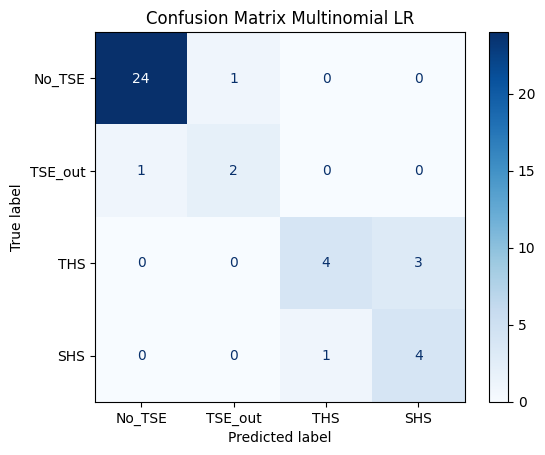

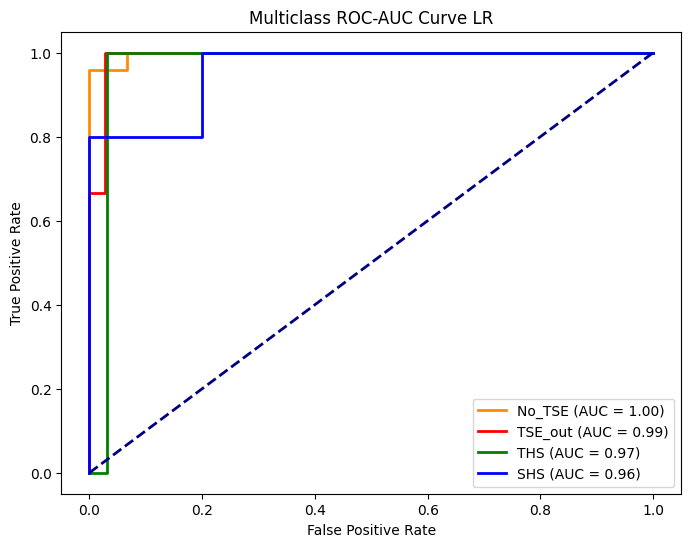

In [40]:

# Define the group mapping for class labels
group_mapping = {0: 'No_TSE', 3: 'TSE_out', 2: 'THS', 1: 'SHS'}

# Define the custom order for class labels
class_order = [0, 3, 2, 1]  # This ensures the classes are ordered as 0, 3, 2, 1

# Predict on validation data
y_pred = logreg.predict(X_valLR)
y_proba = logreg.predict_proba(X_valLR)  # For ROC-AUC

# Calculate common error metrics
accuracy = accuracy_score(Y_val_ordinal, y_pred)
precision = precision_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass
recall = recall_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass
f1 = f1_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass

# For multiclass ROC-AUC, calculate average over classes
roc_auc = roc_auc_score(Y_val_ordinal, y_proba, multi_class='ovr', average='weighted')

# Create a results table
results_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Value": [accuracy, precision, recall, f1, roc_auc]
})

print("Results Table:")
print(results_table)

# Plot the confusion matrix
conf_matrix = confusion_matrix(Y_val_ordinal, y_pred, labels=class_order)  # Ensure the correct class order
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[group_mapping[i] for i in class_order])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Multinomial LR")
plt.show()

# Ensure that Y_val_ordinal is a NumPy array before using ravel()
Y_val_ordinal_np = Y_val_ordinal.values if isinstance(Y_val_ordinal, pd.DataFrame) else Y_val_ordinal
y_proba_np = y_proba if isinstance(y_proba, np.ndarray) else y_proba.values

# Compute ROC curve and ROC area for each class in a one-vs-rest approach
n_classes = y_proba.shape[1]
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

# Compute ROC curve and ROC area for each class
for i in class_order:  # Iterate over classes in the custom order
    fpr[i], tpr[i], _ = roc_curve(Y_val_ordinal_np == i, y_proba_np[:, i])  # One-vs-rest approach
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'blue', 'green', 'red']  # Modify or extend for more classes
for i in class_order:  # Plot in the custom order
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=f'{group_mapping[i]} (AUC = {roc_auc_dict[i]:.2f})')

# Plot the diagonal line (no skill)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC-AUC Curve LR')
plt.legend(loc='lower right')
plt.show()


In [46]:
# Ensure Y_val_ordinal is 1-dimensional
Y_val_ordinal_flat = Y_val_ordinal.values.ravel() if isinstance(Y_val_ordinal, pd.DataFrame) else Y_val_ordinal
y_pred_flat = y_pred.ravel() if isinstance(y_pred, np.ndarray) else y_pred

# Create a DataFrame to compare true labels and predictions, using the index from X_val_df
misclassified_samples = pd.DataFrame({
    "True Label": Y_val_ordinal_flat,
    "Predicted Label": y_pred_flat,
}, index=X_val.index)  # Replace X_val_df with the original DataFrame used to generate X_valLR

# Add a column indicating whether the sample is misclassified
misclassified_samples["Misclassified"] = misclassified_samples["True Label"] != misclassified_samples["Predicted Label"]

# Optionally, map the numeric labels to their class names for easier interpretation
misclassified_samples["True Label Name"] = misclassified_samples["True Label"].map(group_mapping)
misclassified_samples["Predicted Label Name"] = misclassified_samples["Predicted Label"].map(group_mapping)

# Filter the misclassified samples
misclassified = misclassified_samples[misclassified_samples["Misclassified"]]

# Add the ID column from full_ohe based on the index
misclassified_with_id = misclassified.merge(full_ohe[['ID']], left_index=True, right_index=True)

# Display the misclassified samples with ID
print("Misclassified Samples with ID:")
print(misclassified_with_id)


Misclassified Samples with ID:
     True Label  Predicted Label  Misclassified True Label Name  \
139           1                2           True             SHS   
1             3                0           True         TSE_out   
65            2                1           True             THS   
160           0                3           True          No_TSE   
44            2                1           True             THS   
124           2                1           True             THS   

    Predicted Label Name     ID  
139                  THS  EC206  
1                 No_TSE  EC003  
65                   SHS  EC082  
160              TSE_out  EC237  
44                   SHS  EC058  
124                  SHS  EC183  


In [ ]:
coefficients = logreg.coef_  # Coefficients for each class
intercept = logreg.intercept_  # Intercepts for each class
classes = logreg.classes_  # Classes in the model

# Organize coefficients into a DataFrame
feature_names = X_val.columns
coef_df = pd.DataFrame(coefficients.T, columns=[f"Class {cls}" for cls in classes])
coef_df.index = feature_names

# Create intercepts DataFrame
intercept_df = pd.DataFrame(intercept, index=[f"Class {cls}" for cls in classes], columns=["Intercept"])

# Display Model Summary
print("\nModel Summary:")
print("-" * 40)
print("Classes:", classes)
print("\nCoefficients:")
print(coef_df)
coef_df.to_excel('coefficients.xlsx')
print("\nIntercepts:")
print(intercept_df)

# Display Results Table (already created)
print("\nPerformance Metrics:")
print(results_table)


Model Summary:
----------------------------------------
Classes: [0 1 2 3]

Coefficients:
                                         Class 0   Class 1   Class 2   Class 3
8-oxo-dGUO                             -1.048740  6.639519 -3.032168  0.000000
8-OH-guanosine                         -2.933746 -0.347350  0.620314  2.406386
Adenosine                              -2.758481 -4.795713  4.754818  2.803841
Anthranilic                            -7.472333  0.000000  0.000000  6.206900
Cotinine                                0.000000  0.000000  0.000000  0.000000
Dopamine                                0.000000  0.000000  0.046285  0.000000
Epinephrine                            -0.399857  0.625993  0.000000  0.092780
GABA                                    0.000000 -2.165353  2.002842  0.000000
Glutamate                               2.309247 -0.230245  0.000000 -0.676184
Glutamine                               0.949977  0.000000  0.000000 -0.899169
Histamine                               

[[0.21028764 0.1861042  0.44719055 0.1564176 ]
 [0.29072149 0.18337696 0.3701108  0.15579075]
 [0.8762277  0.05899689 0.05025613 0.01451928]
 [0.72706134 0.10319688 0.12869723 0.04104455]
 [0.35249855 0.19751356 0.35281926 0.09716863]
 [0.75796308 0.10240128 0.10352959 0.03610605]
 [0.5239144  0.17466289 0.24911813 0.05230459]
 [0.83892661 0.06319951 0.07881909 0.01905479]
 [0.83034549 0.06541688 0.08478748 0.01945015]
 [0.5576516  0.16672916 0.19540863 0.0802106 ]
 [0.84572461 0.06695479 0.06992579 0.0173948 ]
 [0.87203241 0.05910327 0.05378322 0.0150811 ]
 [0.37283449 0.20342207 0.27944794 0.1442955 ]
 [0.79178371 0.08686601 0.09966909 0.02168119]
 [0.88425228 0.05765789 0.04516808 0.01292175]
 [0.75066485 0.09999647 0.11132924 0.03800944]
 [0.73877544 0.0944403  0.12628986 0.0404944 ]
 [0.71525941 0.11050828 0.14823931 0.02599299]
 [0.90120635 0.04792855 0.03852665 0.01233846]
 [0.86113203 0.06207196 0.06032355 0.01647245]
 [0.38999924 0.20243155 0.31504891 0.09252029]
 [0.76207735 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplo

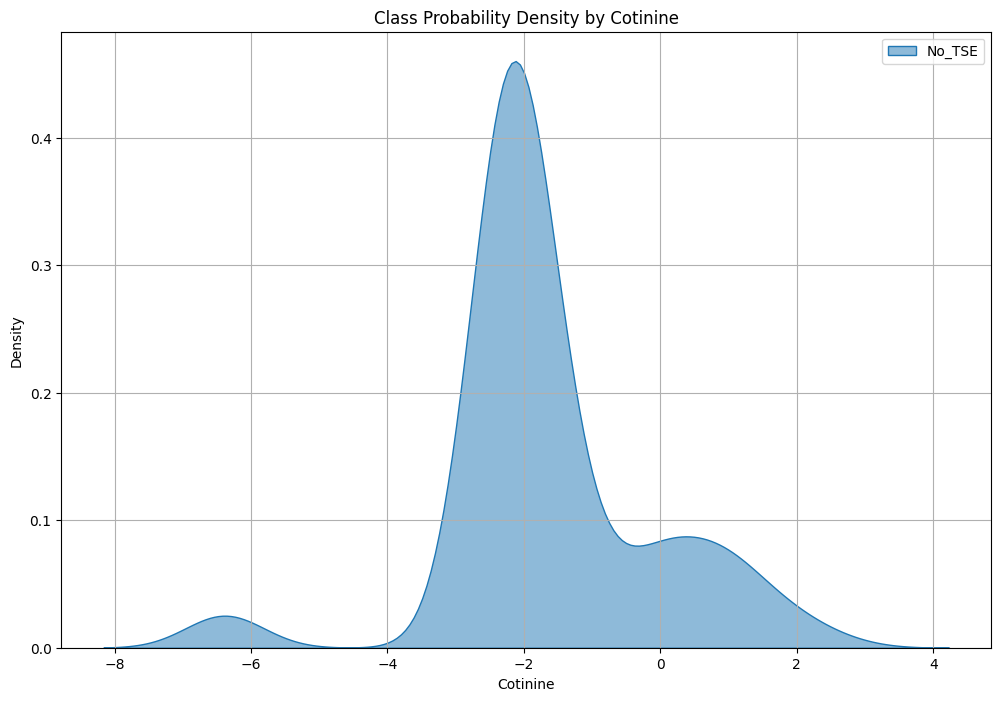

<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


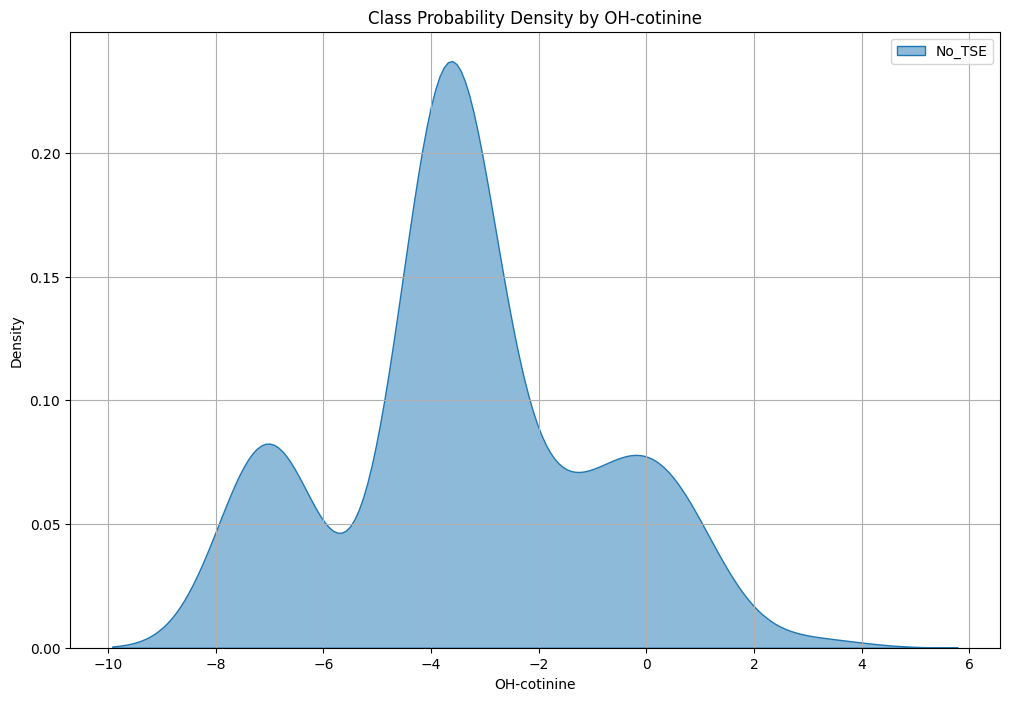

<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-23-fea03c49cf5e>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


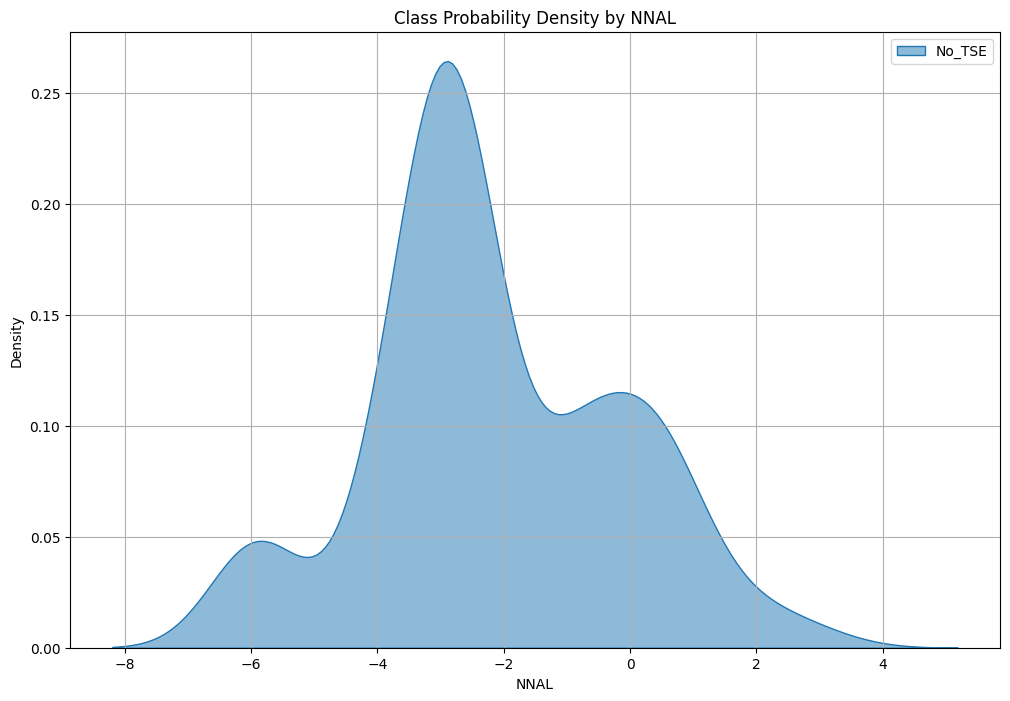

In [ ]:
def plot_class_probability_densities(X_val, y_proba, classes, features, group_mapping):
    """
    Plot the density of class probabilities against multiple features with descriptive class labels.

    Parameters:
    -----------
    X_val : pandas.DataFrame
        Validation data, including the specified features.
    y_proba : array-like
        Predicted class probabilities from logistic regression.
    classes : array-like
        List of class labels.
    features : list of str
        List of feature names to plot.
    group_mapping : dict
        Mapping of numeric class labels to descriptive names.
    """
    # Map numeric class labels to descriptive names
    class_labels = [group_mapping[class_label] for class_label in classes]

    for feature in features:
        plt.figure(figsize=(12, 8))

        # Plot a density plot for each class
        for i, class_label in enumerate(class_labels):
            sns.kdeplot(
                X_val[feature][y_proba[:, i] > 0.5],
                shade=True,
                label=f'{class_label}',
                alpha=0.5
            )

        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.title(f'Class Probability Density by {feature}')
        plt.legend()
        plt.grid()
        plt.show()

# Group mapping
group_mapping = {0: 'No_TSE', 3: 'TSE_out', 2: 'THS', 1: 'SHS'}

# List of features to plot
features_to_plot = ['Cotinine', 'OH-cotinine', 'NNAL']

logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    max_iter=best_params['max_iter'],
    random_state = 24)

# Train the model on the training data and evaluate it with validation data
logreg.fit(X, Y_ordinal.values.ravel())

# Call the function
X_df = pd.DataFrame(X)
y_probaX = logreg.predict_proba(X_df)
print(y_probaX)

plot_class_probability_densities(X_df, y_probaX, logreg.classes_, features_to_plot, group_mapping)


# RANDOM FORESTS
https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/

https://tahera-firdose.medium.com/fine-tuning-your-random-forest-classifier-a-guide-to-hyperparameter-tuning-d5ceab0c4852


In [48]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']}  # Number of features to consider when looking for the best split

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_traintest, Y_traintest_ordinal.values.ravel())

# Best parameters
print("Best Hyperparameters:", grid_search_rf.best_params_)

results_rf = pd.DataFrame(grid_search_rf.cv_results_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [49]:
# Select and rename relevant columns for clarity
results_table_rf = results_rf[[
    "param_n_estimators", "param_max_depth", "param_min_samples_split", "param_min_samples_leaf",
    "param_max_features", "mean_test_score"
]].rename(columns={
    "param_n_estimators": "Number of Estimators",
    "param_max_depth": "Max Depth",
    "param_min_samples_split": "Min Samples Split",
    "param_min_samples_leaf": "Min Samples Leaf",
    "param_max_features": "Max Features",
    "mean_test_score": "Mean Accuracy"
})

# Sort by best accuracy for easier interpretation
results_table_rf = results_table_rf.sort_values(by="Mean Accuracy", ascending=False)

# Group and extract the best combination for each category
best_estimators = results_table_rf.loc[results_table_rf.groupby("Number of Estimators")["Mean Accuracy"].idxmax()]
best_max_depth = results_table_rf.loc[results_table_rf.groupby("Max Depth")["Mean Accuracy"].idxmax()]
best_split = results_table_rf.loc[results_table_rf.groupby("Min Samples Split")["Mean Accuracy"].idxmax()]
best_leaf = results_table_rf.loc[results_table_rf.groupby("Min Samples Leaf")["Mean Accuracy"].idxmax()]

# Display the tables
print("Best Combination for Each Number of Estimators:")
print(best_estimators)

print("\nBest Combination for Each Max Depth:")
print(best_max_depth)

print("\nBest Combination for Each Min Samples Split:")
print(best_split)

print("\nBest Combination for Each Min Samples Leaf:")
print(best_leaf)

Best Combination for Each Number of Estimators:
     Number of Estimators Max Depth  Min Samples Split  Min Samples Leaf  \
165                    50      None                  5                 1   
166                   100      None                  5                 1   
2                     200        10                  2                 1   

    Max Features  Mean Accuracy  
165         sqrt       0.878427  
166         sqrt       0.878427  
2           sqrt       0.885081  

Best Combination for Each Max Depth:
     Number of Estimators Max Depth  Min Samples Split  Min Samples Leaf  \
2                     200        10                  2                 1   
56                    200        20                  2                 1   
110                   200        30                  2                 1   

    Max Features  Mean Accuracy  
2           sqrt       0.885081  
56          sqrt       0.885081  
110         sqrt       0.885081  

Best Combination for Each Min S

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8850806451612904
Validation Accuracy: 0.9
Results Table:
      Metric     Value
0   Accuracy  0.900000
1  Precision  0.914815
2     Recall  0.900000
3   F1 Score  0.885337
4    ROC-AUC  0.971300


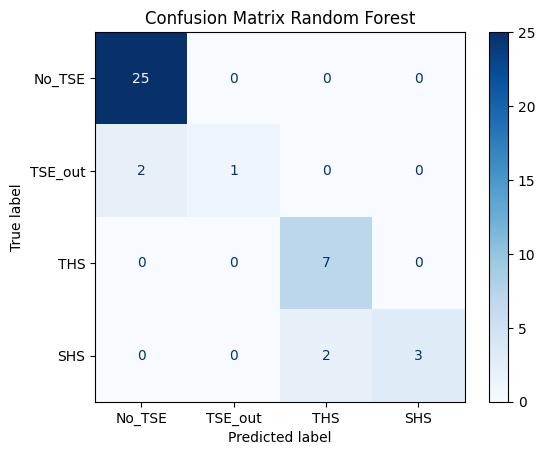

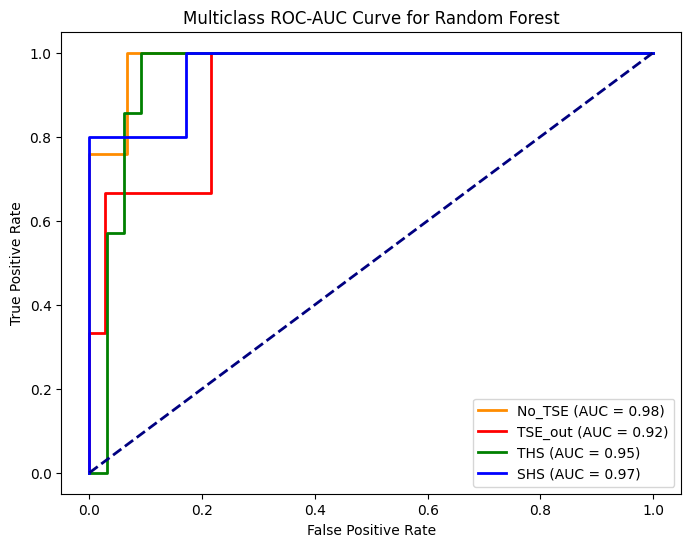


Performance Metrics:
      Metric     Value
0   Accuracy  0.900000
1  Precision  0.914815
2     Recall  0.900000
3   F1 Score  0.885337
4    ROC-AUC  0.971300


In [50]:
# Fit Random Forest with the best parameters and use validation data to test it
best_params_rf = grid_search_rf.best_params_
rf_best = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)

# Train the model on the training data and evaluate it with validation data
rf_best.fit(X_traintest, Y_traintest_ordinal.values.ravel())
validation_accuracy_rf = rf_best.score(X_val, Y_val_ordinal.values.ravel())

# Display the results
print("Best Parameters:", best_params_rf)
print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)
print("Validation Accuracy:", validation_accuracy_rf)

# Predict on validation data
y_pred_rf = rf_best.predict(X_val)
y_proba_rf = rf_best.predict_proba(X_val)  # For ROC-AUC

# Calculate common error metrics
accuracy_rf = accuracy_score(Y_val_ordinal, y_pred_rf)
precision_rf = precision_score(Y_val_ordinal, y_pred_rf, average='weighted')  # Weighted average for multiclass
recall_rf = recall_score(Y_val_ordinal, y_pred_rf, average='weighted')  # Weighted average for multiclass
f1_rf = f1_score(Y_val_ordinal, y_pred_rf, average='weighted')  # Weighted average for multiclass

# For multiclass ROC-AUC, calculate average over classes
roc_auc_rf = roc_auc_score(Y_val_ordinal, y_proba_rf, multi_class='ovr', average='weighted')

# Create a results table
results_table_rf_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Value": [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]
})

print("Results Table:")
print(results_table_rf_metrics)

# Plot the confusion matrix
conf_matrix = confusion_matrix(Y_val_ordinal, y_pred_rf, labels=class_order)  # Ensure the correct class order
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[group_mapping[i] for i in class_order])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Random Forest")
plt.show()

# Compute ROC curve and ROC area for each class in a one-vs-rest approach
fpr_rf = dict()
tpr_rf = dict()
roc_auc_dict_rf = dict()

# Compute ROC curve and ROC area for each class
for i in class_order:  # Iterate over classes in the custom order
    fpr_rf[i], tpr_rf[i], _ = roc_curve(Y_val_ordinal.values == i, y_proba_rf[:, i])  # One-vs-rest approach
    roc_auc_dict_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'blue', 'green', 'red']  # Modify or extend for more classes
for i in class_order:  # Plot in the custom order
    plt.plot(fpr_rf[i], tpr_rf[i], color=colors[i % len(colors)], lw=2, label=f'{group_mapping[i]} (AUC = {roc_auc_dict_rf[i]:.2f})')

# Plot the diagonal line (no skill)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC-AUC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

# Display Performance Metrics
print("\nPerformance Metrics:")
print(results_table_rf_metrics)

In [51]:
# Ensure Y_val_ordinal is 1-dimensional
Y_val_ordinal_flat = Y_val_ordinal.values.ravel() if isinstance(Y_val_ordinal, pd.DataFrame) else Y_val_ordinal
y_pred_flat = y_pred_rf.ravel() if isinstance(y_pred_rf, np.ndarray) else y_pred_rf

# Create a DataFrame to compare true labels and predictions, using the index from X_val_df
misclassified_samples = pd.DataFrame({
    "True Label": Y_val_ordinal_flat,
    "Predicted Label": y_pred_flat,
}, index=X_val.index)  # Replace X_val_df with the original DataFrame used to generate X_valLR

# Add a column indicating whether the sample is misclassified
misclassified_samples["Misclassified"] = misclassified_samples["True Label"] != misclassified_samples["Predicted Label"]

# Optionally, map the numeric labels to their class names for easier interpretation
misclassified_samples["True Label Name"] = misclassified_samples["True Label"].map(group_mapping)
misclassified_samples["Predicted Label Name"] = misclassified_samples["Predicted Label"].map(group_mapping)

# Filter the misclassified samples
misclassified = misclassified_samples[misclassified_samples["Misclassified"]]

# Add the ID column from full_ohe based on the index
misclassified_with_id = misclassified.merge(full_ohe[['ID']], left_index=True, right_index=True)

# Display the misclassified samples with ID
print("Misclassified Samples with ID:")
print(misclassified_with_id)


Misclassified Samples with ID:
     True Label  Predicted Label  Misclassified True Label Name  \
139           1                2           True             SHS   
1             3                0           True         TSE_out   
94            1                2           True             SHS   
52            3                0           True         TSE_out   

    Predicted Label Name     ID  
139                  THS  EC206  
1                 No_TSE  EC003  
94                   THS  EC125  
52                No_TSE  EC066  


                                   Feature  Importance
28               Parents_liv_tog_No casado    0.002085
27  Parents_liv_tog_Casado/a, emparejado/a    0.002386
23                      Cigarettes_in_home    0.002908
25                             Parents_edu    0.005743
26                                  Income    0.007230
9                                Glutamine    0.011579
15                          Norepinephrine    0.013811
7                                     GABA    0.014279
11                          Kynurenic acid    0.014358
8                                Glutamate    0.014378
20                        Xanthurenic acid    0.014647
13                               Melatonin    0.015998
19                              Tryptophan    0.018421
12                              Kynurenine    0.019944
6                              Epinephrine    0.021373
1                           8-OH-guanosine    0.022973
16                             OH-cotinine    0.025672
14        

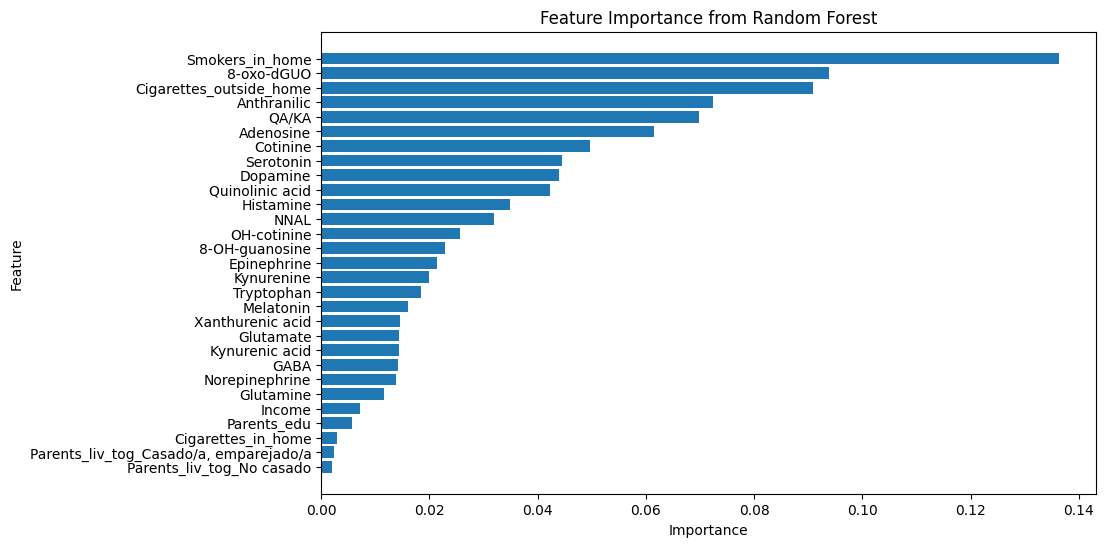

In [ ]:
# Fetaure importance
feature_importances = rf_best.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_traintest.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.show()

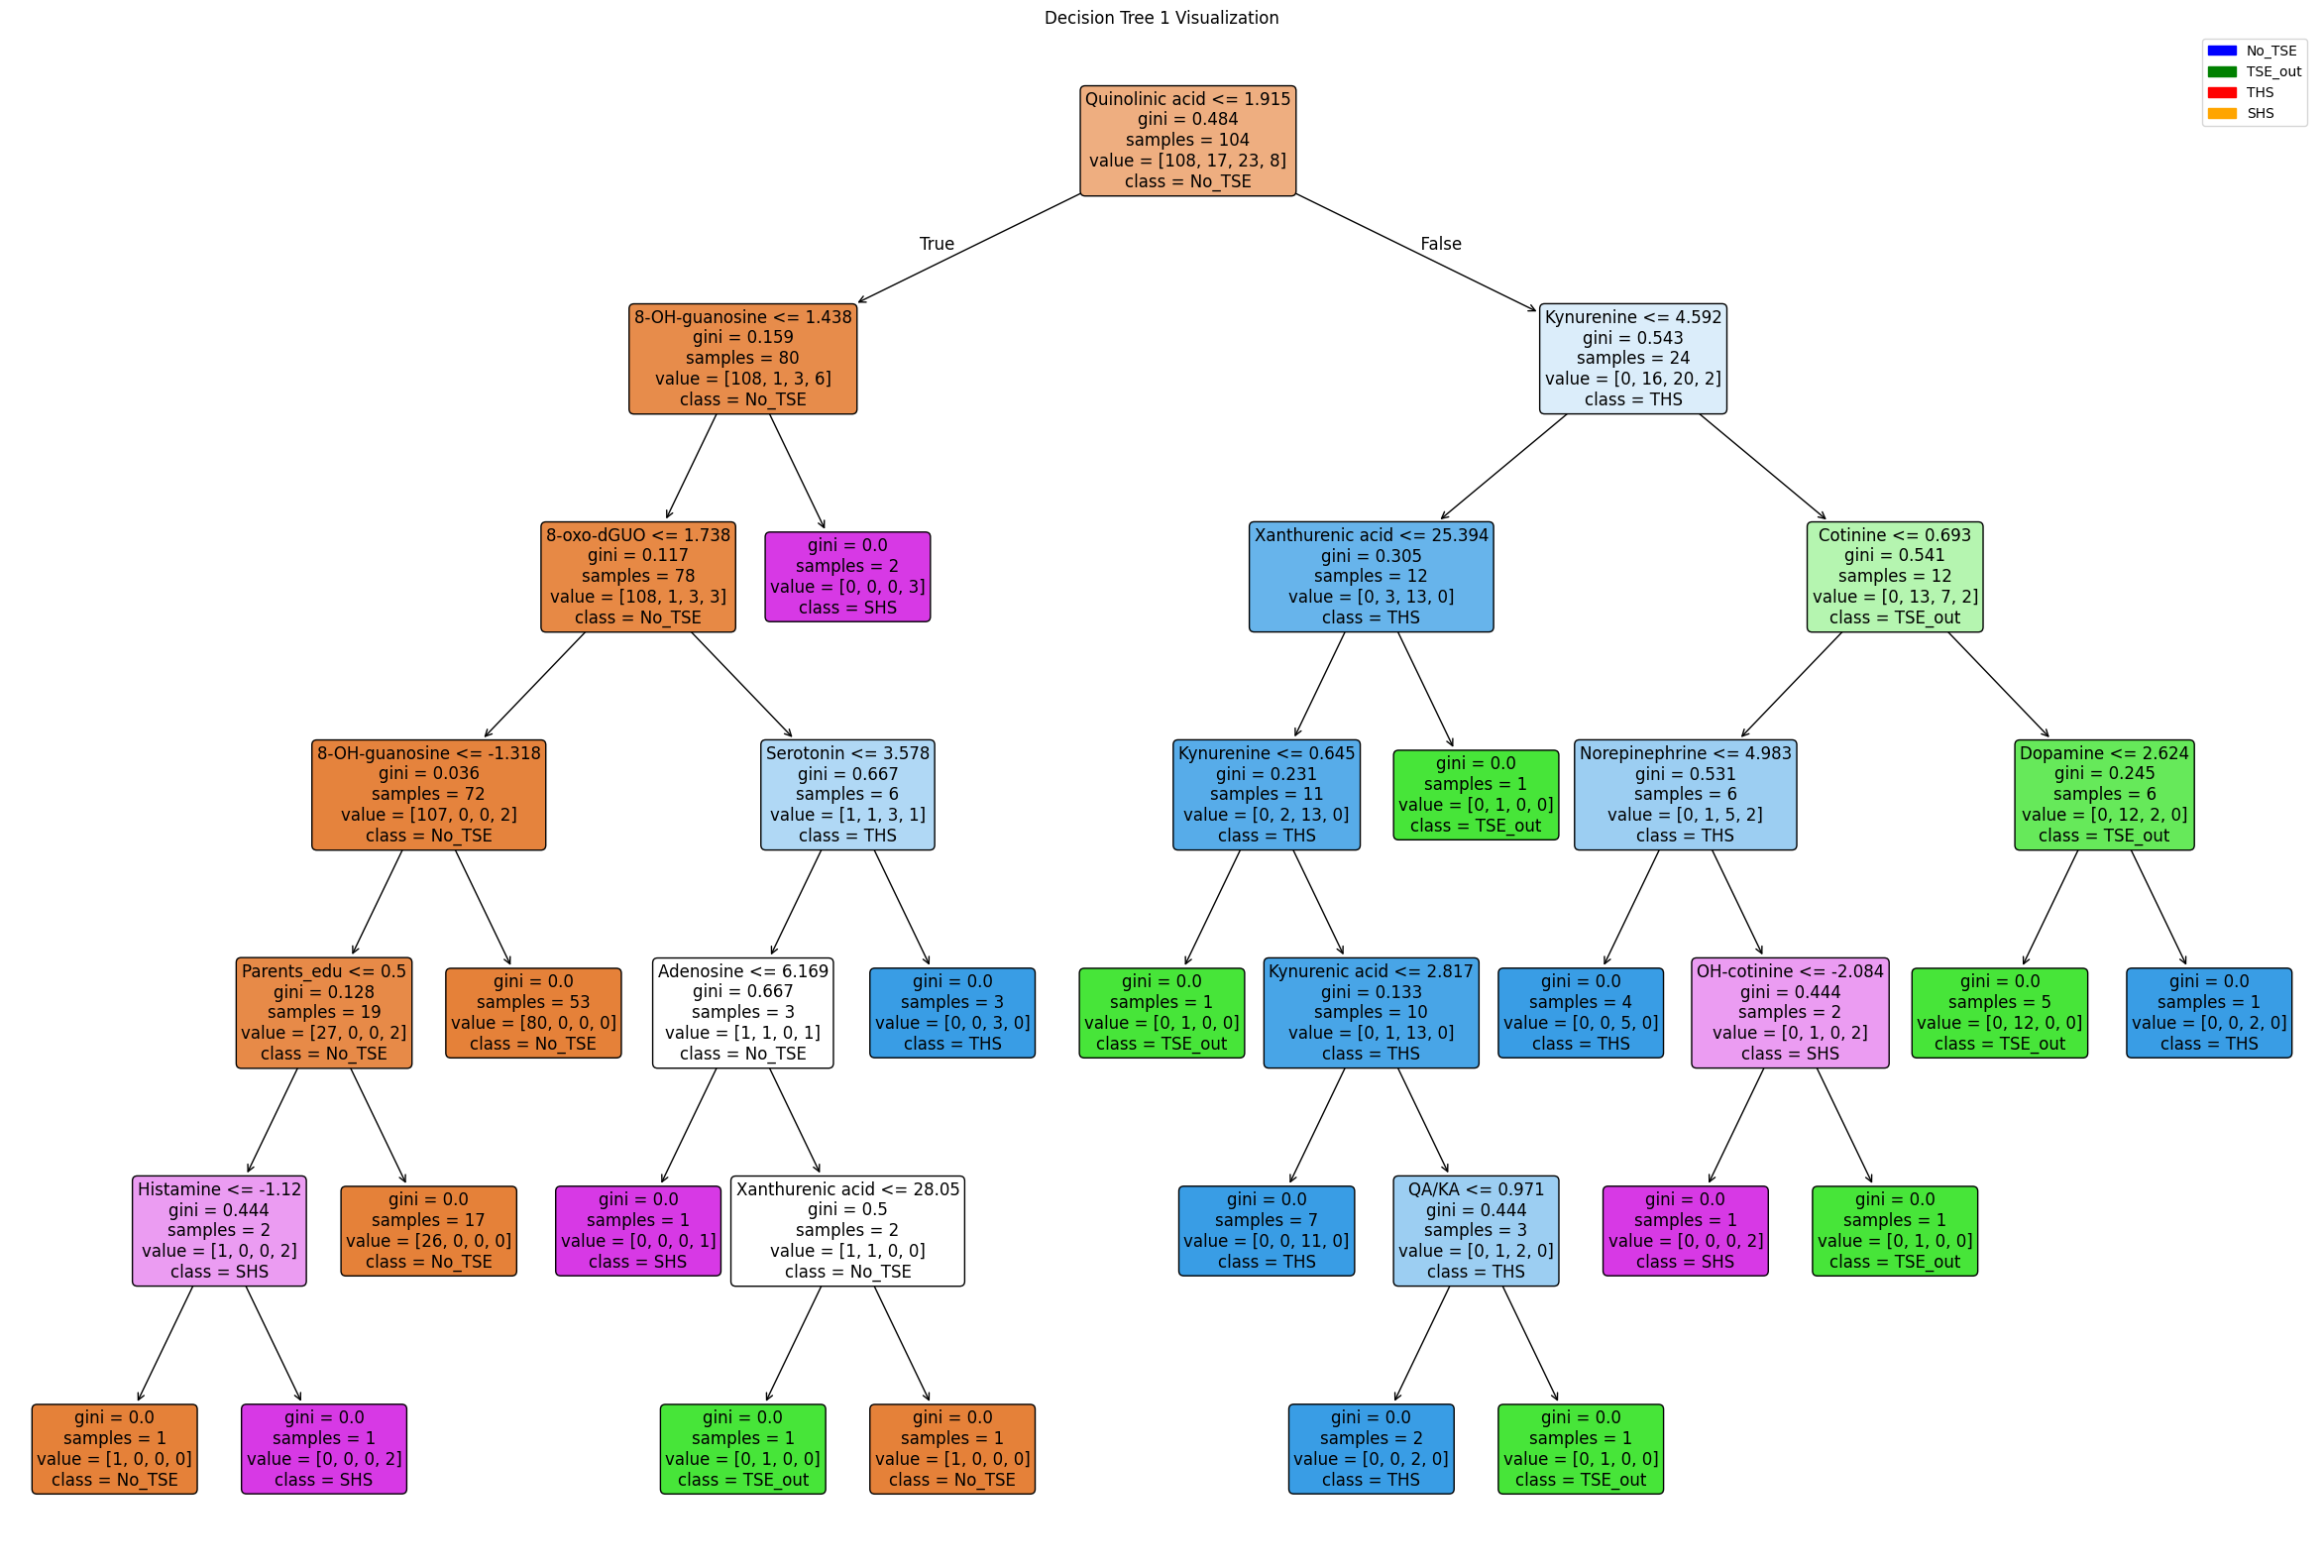

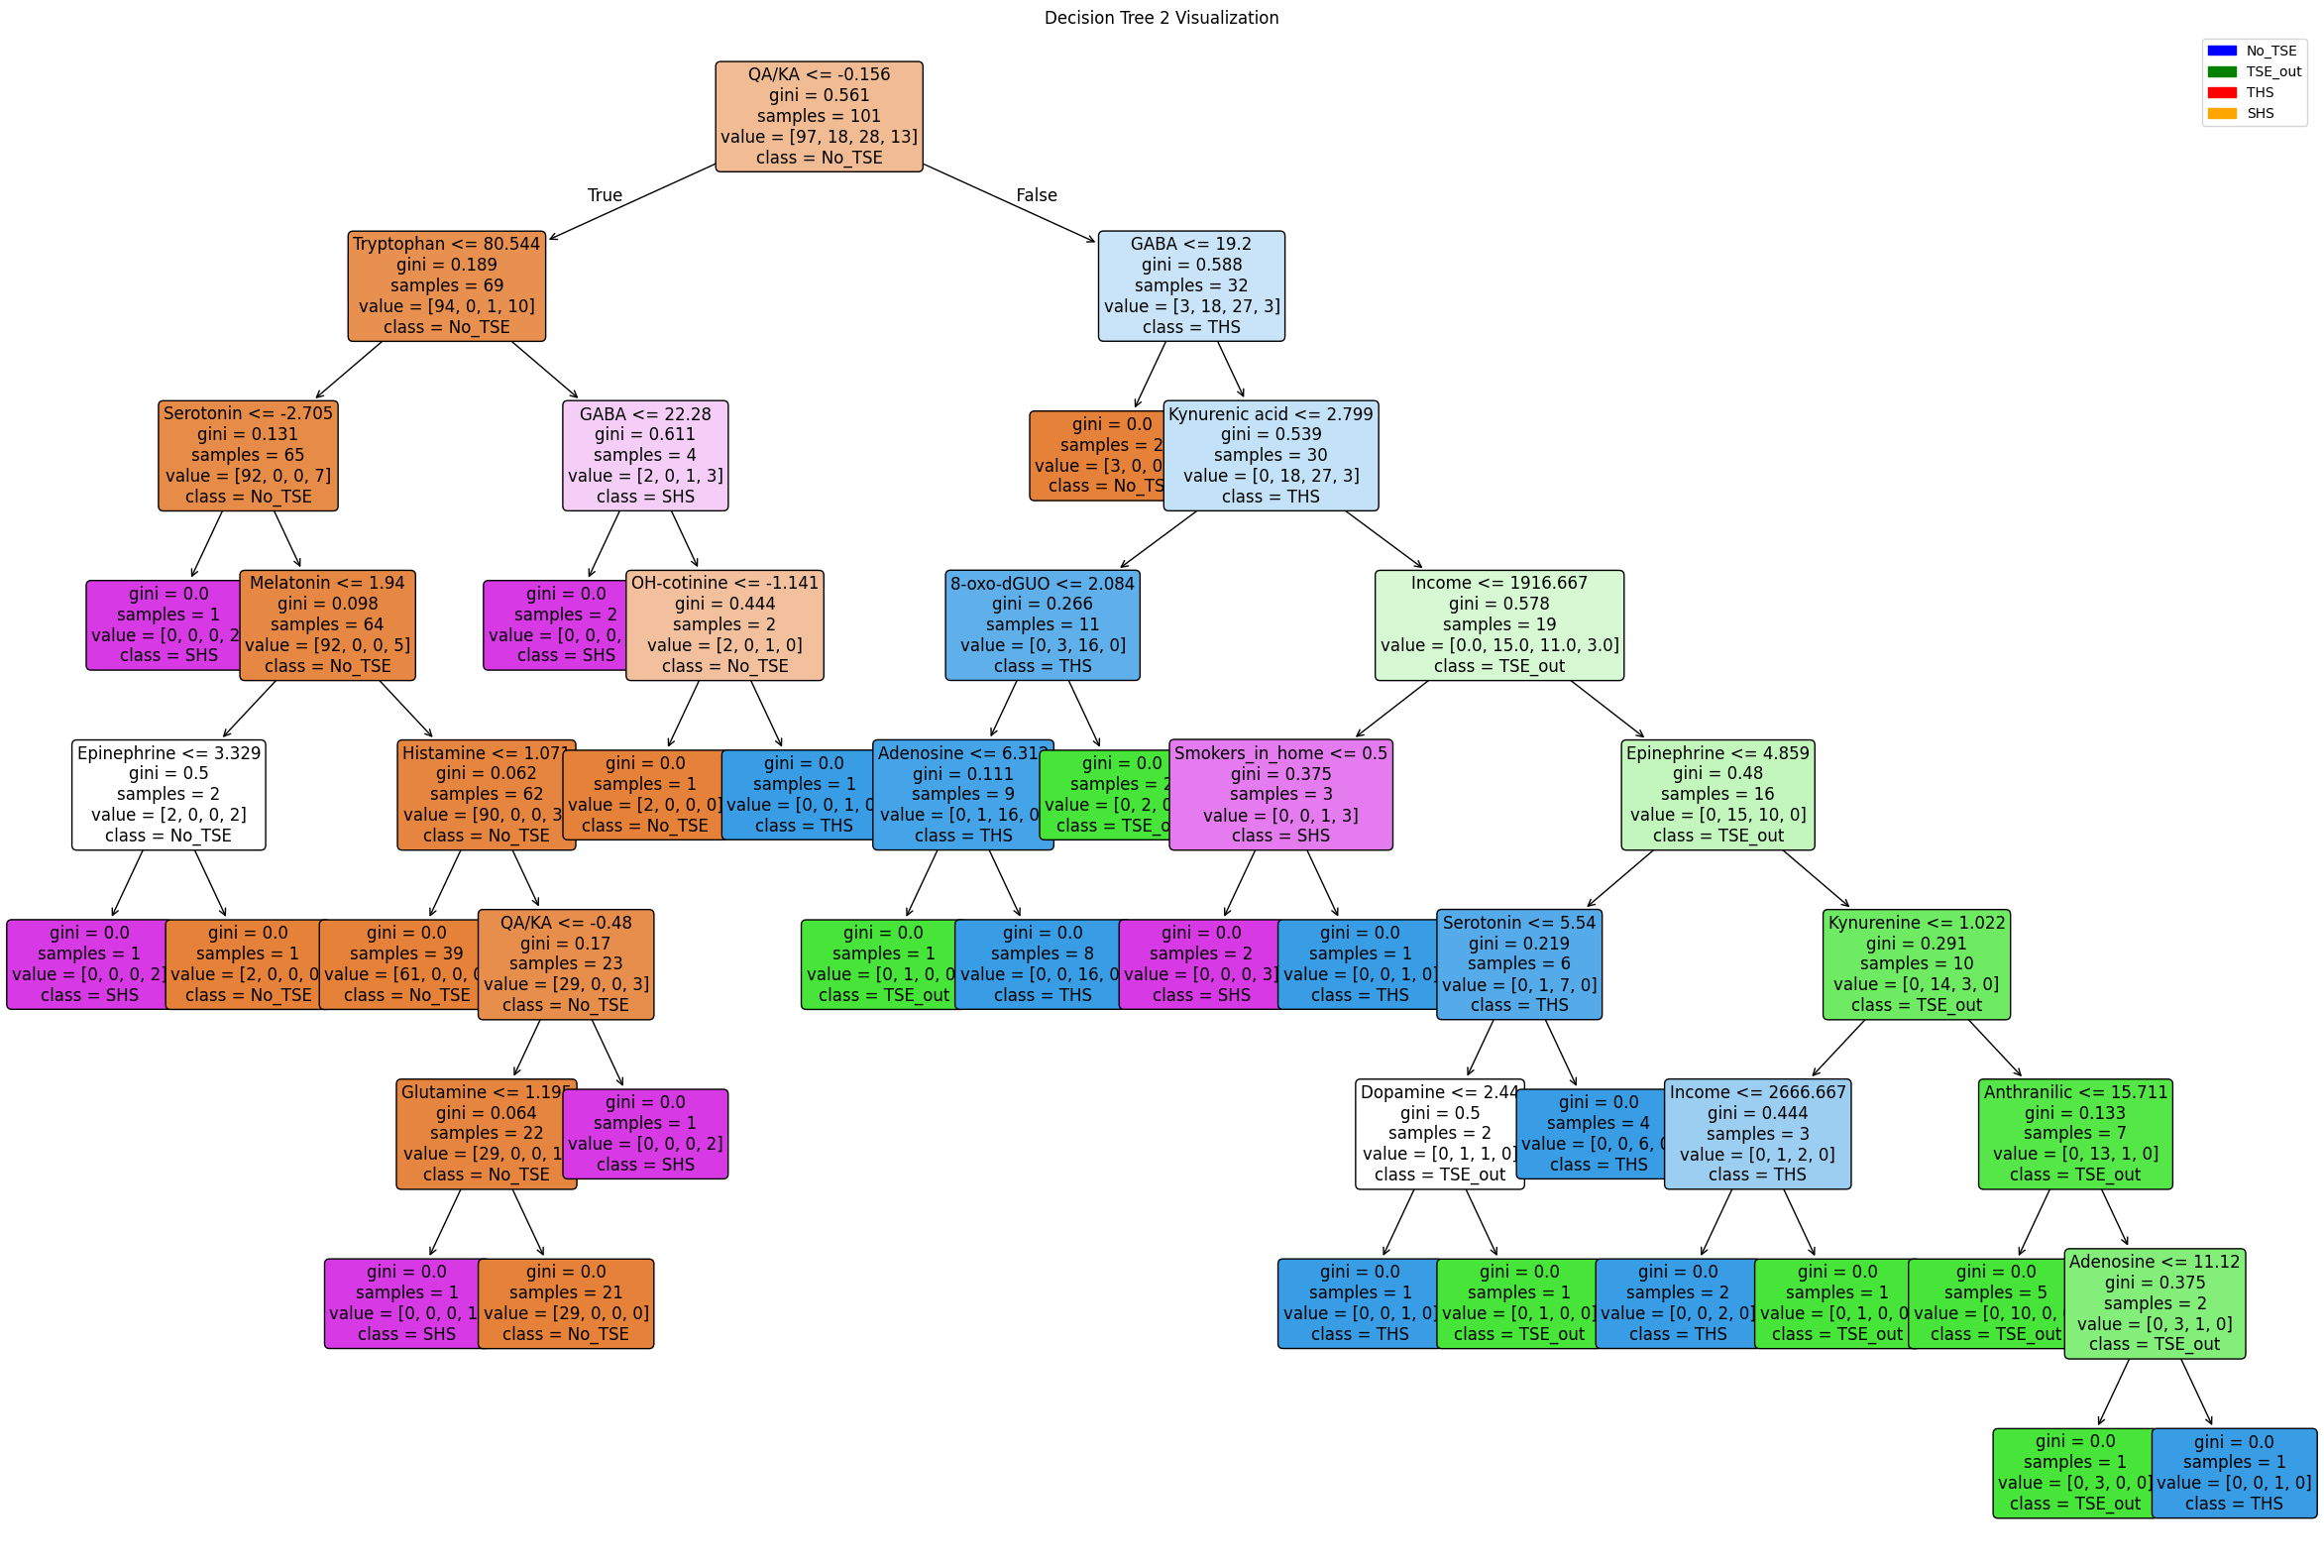

In [ ]:
n_trees = 2  # Number of trees to visualize
class_colors = ['blue', 'green', 'red', 'orange']
for n_tree in range(n_trees):
    tree = rf_best.estimators_[n_tree]
    plt.figure(figsize=(30, 20))
    plot_tree(tree, filled=True, feature_names=X.columns, class_names=[str(i) for i in group_mapping.values()], rounded=True, fontsize=12)
    plt.title(f"Decision Tree {n_tree + 1} Visualization")
    legend_patches = [mpatches.Patch(color=color, label=label)
                      for label, color in zip(group_mapping.values(), class_colors)]

    # Add the legend to the plot
    plt.legend(handles=legend_patches, loc='best')
    plt.show()


# SVM
Needs scaled data

https://medium.com/@prayushshrestha89/tuning-svm-hyperparameters-making-your-classifier-shine-like-a-pro-8673639ddb16


In [52]:
# Model and CV for hyperparameters
SVM = SVC()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'], # kernel types
    'gamma': [0.1, 1, 10], # Flexibilty and complexity
    'degree': [1, 2, 3,4]} # degree for poly kernel

grid_search = GridSearchCV(SVM,param_grid= param_grid,cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_traintestLR,Y_traintest_ordinal.values.ravel())

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'C': 1, 'degree': 1, 'gamma': 10, 'kernel': 'poly'}


In [53]:
# Extract results into a DataFrame for clarity
results = pd.DataFrame(grid_search.cv_results_)

# Select and rename relevant columns for clarity
results_table = results[[
    "param_kernel", "param_C", "param_gamma", "param_degree", "mean_test_score"
]].rename(columns={
    "param_kernel": "Kernel",
    "param_C": "C (Regularization)",
    "param_gamma": "Gamma",
    "param_degree": "Degree",
    "mean_test_score": "Mean Accuracy"
})

# Sort by best accuracy for easier interpretation
results_table = results_table.sort_values(by="Mean Accuracy", ascending=False)

# Group and extract the best combination for each category
best_kernel = results_table.loc[results_table.groupby("Kernel")["Mean Accuracy"].idxmax()]
best_c = results_table.loc[results_table.groupby("C (Regularization)")["Mean Accuracy"].idxmax()]
best_gamma = results_table.loc[results_table.groupby("Gamma")["Mean Accuracy"].idxmax()]
best_degree = results_table.loc[results_table.groupby("Degree")["Mean Accuracy"].idxmax()]

# Display the tables
print("Best Combination for Each Kernel:")
print(best_kernel)

print("\nBest Combination for Each C Parameter:")
print(best_c)

print("\nBest Combination for Each Gamma Parameter:")
print(best_gamma)

print("\nBest Combination for Each Degree Parameter:")
print(best_degree)


Best Combination for Each Kernel:
     Kernel  C (Regularization)  Gamma  Degree  Mean Accuracy
108  linear                10.0    0.1       1       0.884677
146    poly               100.0    0.1       1       0.884677
145     rbf               100.0    0.1       1       0.852621

Best Combination for Each C Parameter:
     Kernel  C (Regularization)  Gamma  Degree  Mean Accuracy
17     poly                0.01   10.0       2       0.859073
53     poly                0.10   10.0       2       0.852823
80     poly                1.00   10.0       1       0.884677
108  linear               10.00    0.1       1       0.884677
146    poly              100.00    0.1       1       0.884677
180  linear             1000.00    0.1       1       0.865323

Best Combination for Each Gamma Parameter:
     Kernel  C (Regularization)  Gamma  Degree  Mean Accuracy
108  linear                10.0    0.1       1       0.884677
138  linear                10.0    1.0       4       0.884677
123  linear   

Best Parameters: {'C': 1, 'degree': 1, 'gamma': 10, 'kernel': 'poly'}
Best Cross-Validation Accuracy: 0.8846774193548388
Validation Accuracy: 0.9
Results Table:
      Metric     Value
0   Accuracy  0.900000
1  Precision  0.905128
2     Recall  0.900000
3   F1 Score  0.898270


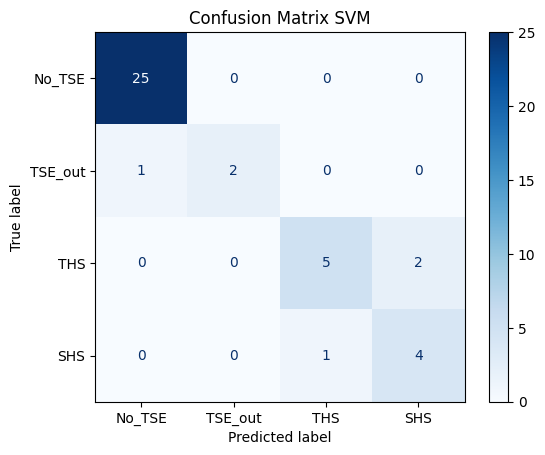

In [54]:
# Fit SVM with the best parameters and use validation data to test it
best_params = grid_search.best_params_
"""SVM = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'],
    degree=best_params['degree']
)"""
SVM = SVC(
    C=10,
    kernel='linear',
    gamma=0.1,
    degree=1,
    decision_function_shape='ovr'
)

# Train the model on the training data and evaluate it with validation data
SVM.fit(X_traintestLR, Y_traintest_ordinal.values.ravel())
validation_accuracy = SVM.score(X_valLR, Y_val_ordinal.values.ravel())

# Display the results
print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("Validation Accuracy:", validation_accuracy)

# Predict on validation data
y_pred_SVM = SVM.predict(X_valLR)

# Calculate common error metrics
accuracy = accuracy_score(Y_val_ordinal, y_pred_SVM)
precision = precision_score(Y_val_ordinal, y_pred_SVM, average='weighted')  # Weighted average for multiclass
recall = recall_score(Y_val_ordinal, y_pred_SVM, average='weighted')  # Weighted average for multiclass
f1 = f1_score(Y_val_ordinal, y_pred_SVM, average='weighted')  # Weighted average for multiclass

# Create a results table
results_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [accuracy, precision, recall, f1]
})

print("Results Table:")
print(results_table)

# Plot the confusion matrix
conf_matrix = confusion_matrix(Y_val_ordinal, y_pred_SVM, labels=class_order)  # Ensure the correct class order
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[group_mapping[i] for i in class_order])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix SVM")
plt.show()


In [55]:
# Ensure Y_val_ordinal is 1-dimensional
Y_val_ordinal_flat = Y_val_ordinal.values.ravel() if isinstance(Y_val_ordinal, pd.DataFrame) else Y_val_ordinal
y_pred_flat = y_pred_SVM.ravel() if isinstance(y_pred_SVM, np.ndarray) else y_pred_SVM

# Create a DataFrame to compare true labels and predictions, using the index from X_val_df
misclassified_samples = pd.DataFrame({
    "True Label": Y_val_ordinal_flat,
    "Predicted Label": y_pred_flat,
}, index=X_val.index)  # Replace X_val_df with the original DataFrame used to generate X_valLR

# Add a column indicating whether the sample is misclassified
misclassified_samples["Misclassified"] = misclassified_samples["True Label"] != misclassified_samples["Predicted Label"]

# Optionally, map the numeric labels to their class names for easier interpretation
misclassified_samples["True Label Name"] = misclassified_samples["True Label"].map(group_mapping)
misclassified_samples["Predicted Label Name"] = misclassified_samples["Predicted Label"].map(group_mapping)

# Filter the misclassified samples
misclassified = misclassified_samples[misclassified_samples["Misclassified"]]

# Add the ID column from full_ohe based on the index
misclassified_with_id = misclassified.merge(full_ohe[['ID']], left_index=True, right_index=True)

# Display the misclassified samples with ID
print("Misclassified Samples with ID:")
print(misclassified_with_id)


Misclassified Samples with ID:
     True Label  Predicted Label  Misclassified True Label Name  \
139           1                2           True             SHS   
165           2                1           True             THS   
52            3                0           True         TSE_out   
44            2                1           True             THS   

    Predicted Label Name     ID  
139                  THS  EC206  
165                  SHS  EC242  
52                No_TSE  EC066  
44                   SHS  EC058  


In [ ]:
y_pred_svm = SVM.predict(X_val)
y_proba_svm = rf_best.predict_proba(X_val)  # For ROC-AUC

# Calculate common error metrics
accuracy_rf = accuracy_score(Y_val_ordinal, y_pred_rf)
precision_rf = precision_score(Y_val_ordinal, y_pred_rf, average='weighted')  # Weighted average for multiclass
recall_rf = recall_score(Y_val_ordinal, y_pred_rf, average='weighted')  # Weighted average for multiclass
f1_rf = f1_score(Y_val_ordinal, y_pred_rf, average='weighted')  # Weighted average for multiclass

# For multiclass ROC-AUC, calculate average over classes
roc_auc_rf = roc_auc_score(Y_val_ordinal, y_proba_rf, multi_class='ovr', average='weighted')

# Create a results table
results_table_rf_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Value": [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]
})

print("Results Table:")
print(results_table_rf_metrics)

# Plot the confusion matrix
conf_matrix = confusion_matrix(Y_val_ordinal, y_pred_rf, labels=class_order)  # Ensure the correct class order
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[group_mapping[i] for i in class_order])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Random Forest")
plt.show()

# Compute ROC curve and ROC area for each class in a one-vs-rest approach
fpr_rf = dict()
tpr_rf = dict()
roc_auc_dict_rf = dict()

# Compute ROC curve and ROC area for each class
for i in class_order:  # Iterate over classes in the custom order
    fpr_rf[i], tpr_rf[i], _ = roc_curve(Y_val_ordinal.values == i, y_proba_rf[:, i])  # One-vs-rest approach
    roc_auc_dict_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'blue', 'green', 'red']  # Modify or extend for more classes
for i in class_order:  # Plot in the custom order
    plt.plot(fpr_rf[i], tpr_rf[i], color=colors[i % len(colors)], lw=2, label=f'{group_mapping[i]} (AUC = {roc_auc_dict_rf[i]:.2f})')

# Plot the diagonal line (no skill)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC-AUC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

# Display Performance Metrics
print("\nPerformance Metrics:")
print(results_table_rf_metrics)

In [ ]:
# Get the pairwise class comparisons
class_pairs = list(combinations(SVM.classes_, 2))

# Map class numbers to their names
class_pairs_named = [(group_mapping[pair[0]], group_mapping[pair[1]]) for pair in class_pairs]

# Create a DataFrame with coefficients and class pair labels
coef_df = pd.DataFrame(SVM.coef_, columns=X_valLR_df.columns)
coef_df['Class Pair'] = [f"{pair[0]} vs {pair[1]}" for pair in class_pairs_named]

# Reorder columns for better readability
coef_df = coef_df[['Class Pair'] + list(X_valLR_df.columns)]

# Display the DataFrame
print(coef_df)



          Class Pair  8-oxo-dGUO  8-OH-guanosine  Adenosine  Anthranilic  \
0      No_TSE vs SHS   -0.881947       -0.011009  -0.594407    -0.656357   
1      No_TSE vs THS   -0.745994       -0.121698  -0.539217    -0.826570   
2  No_TSE vs TSE_out   -0.625502       -2.700293  -2.477946    -4.880309   
3         SHS vs THS    4.937774       -0.160427  -6.405330     1.343465   
4     SHS vs TSE_out    0.858957       -0.043646   0.246216     0.047005   
5     THS vs TSE_out    0.201955        0.119680   0.068769    -0.105071   

   Cotinine  Dopamine  Epinephrine      GABA  Glutamate  ...  Tryptophan  \
0 -0.307945 -0.426819    -0.302921 -0.000502   0.024227  ...    0.141924   
1 -0.116447 -0.126137     0.100840 -0.121905   0.139430  ...    0.399465   
2 -0.132976 -0.154208    -1.050740  0.306264   2.233925  ...   -1.607340   
3  0.802073 -0.149582     0.813783 -2.297753  -0.781949  ...   -1.350835   
4  0.593471  0.450131     0.157777  0.181435  -0.043641  ...   -0.317347   
5  0.446613

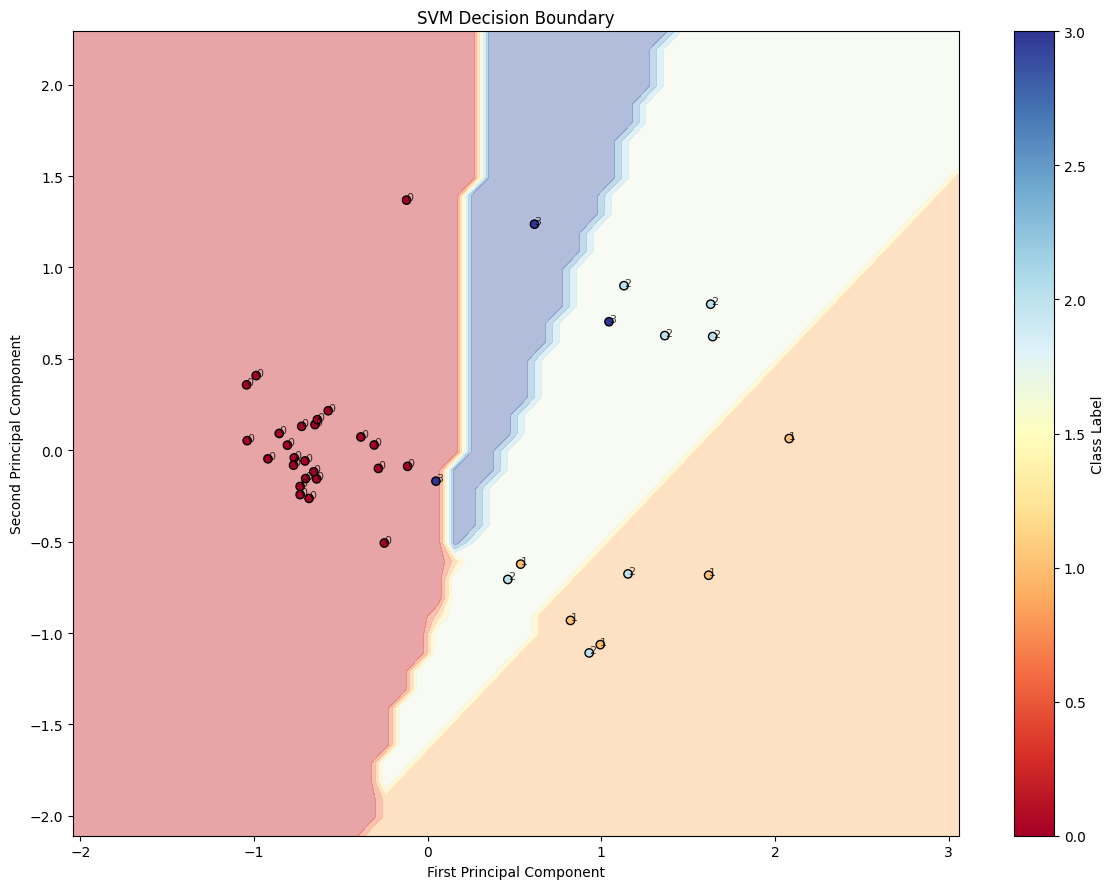

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

def plot_decision_boundary(X, y, class_order, group_mapping):
    """
    Visualize the SVM decision boundary using PCA for dimensionality reduction

    Parameters:
    - X: Input features
    - y: Target labels
    - class_order: Order of classes
    - group_mapping: Mapping of class labels
    """

    # Use PCA to reduce to 2 dimensions for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Train SVM on PCA-transformed data
    SVM = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'],
    degree=best_params['degree'],
    probability=True
    )
    SVM.fit(X_pca, y)

    # Create a mesh to plot the decision boundary
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict for each point in the mesh
    Z = SVM.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

 # Plot the decision boundary
    plt.figure(figsize=(12, 9))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

    # Plot the original data points
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')

    # Add labels to the points
    for i, (x, y_val) in enumerate(zip(X_pca[:, 0], X_pca[:, 1])):
        plt.annotate(f"{int(y[i])}", (x, y_val), fontsize=8, alpha=0.75)

    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('SVM Decision Boundary')

    plt.colorbar(scatter, label='Class Label')
    plt.tight_layout()
    plt.show()

# Call the function with your specific data and mappings
plot_decision_boundary(X_valLR, Y_val_ordinal.values.ravel(), class_order, group_mapping)

# ANN
https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

1. One Hidden Layer 10 nodes
2. Two Hiddel Layers 15 and 7 nodes

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2


In [ ]:
!pip install scikit-learn==1.5.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 61.4 MB/s eta 0:00:00


In [ ]:
! pip install keras
! pip install scikeras
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy
from keras import layers
from keras import models
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


## 1Hidden Layer, 10 nodes

- Optimizing weigth initialization
- Optimizing Dropout rate
- Optimizing Optimizer
- Optimizing Batch size




In [56]:
# Scale the data using StandardScaler
scaler = StandardScaler()
X_traintestANN_scaled = scaler.fit_transform(X_traintest)
X_valANN_scaled = scaler.transform(X_val)
X_valANN_scaled.shape

(40, 29)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5295 - loss: 1.3187
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6516 - loss: 0.9209
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8042 - loss: 0.6179
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8139 - loss: 0.4835
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8707 - loss: 0.3738
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8745 - loss: 0.3655
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8006 - loss: 0.4359
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8003 - loss: 0.4308
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.3643
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7346 - loss: 0.4228
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7539 - loss: 0.4444
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

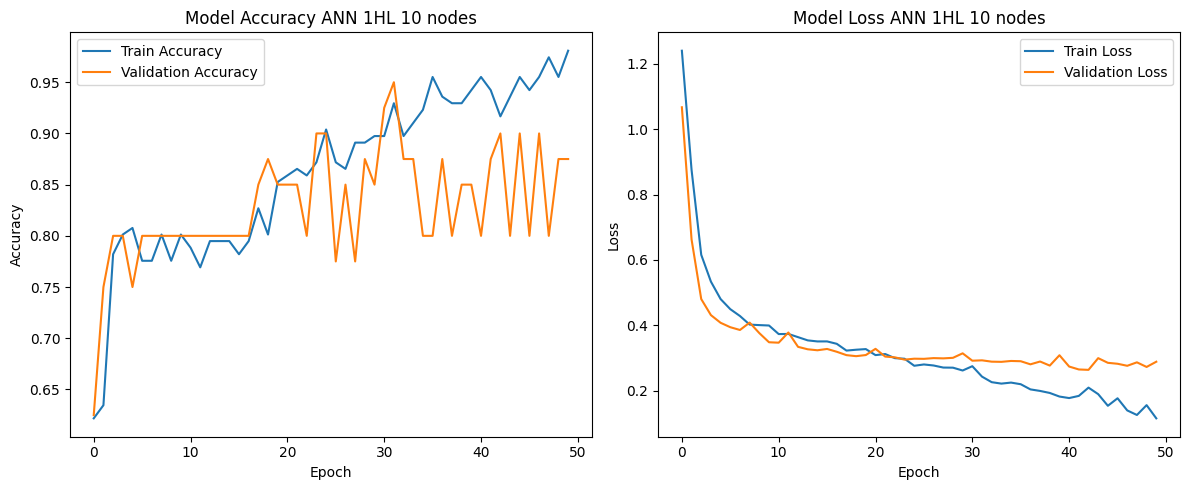

In [57]:


# Define the function to create the Keras model
def create_model(init_mode='uniform', optimizer='rmsprop', dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(10, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=29))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, kernel_initializer=init_mode, activation=tf.nn.softmax))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Define the hyperparameter grid
param_grid = {
    'model__init_mode': ['uniform', 'normal'],
    'model__optimizer': ['rmsprop', 'sgd'],
    'model__dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [1, 5, 10],  # Smaller batch sizes due to limited dataset size
    'epochs': [50]
}

# Create the KerasClassifier wrapper
model = KerasClassifier(model=create_model, verbose=1)

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_traintestANN_scaled, Y_traintest_ohe)

# Display the best hyperparameters and accuracy
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)

# Extract the best model and train it further
best_params = grid_result.best_params_

# Create the best model using the extracted best parameters
best_model = create_model(
    init_mode=best_params['model__init_mode'],
    optimizer=best_params['model__optimizer'],
    dropout_rate=best_params['model__dropout_rate']
)

# Train the best model further
history = best_model.fit(
    X_traintestANN_scaled, Y_traintest_ohe,
    validation_data=(X_valANN_scaled, Y_val_ohe),
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    verbose=1
)

# Function to plot accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy ANN 1HL 10 nodes')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss ANN 1HL 10 nodes')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Results Table:
      Metric     Value
0   Accuracy  0.875000
1  Precision  0.875534
2     Recall  0.875000
3   F1 Score  0.865110
4    ROC-AUC  0.987355


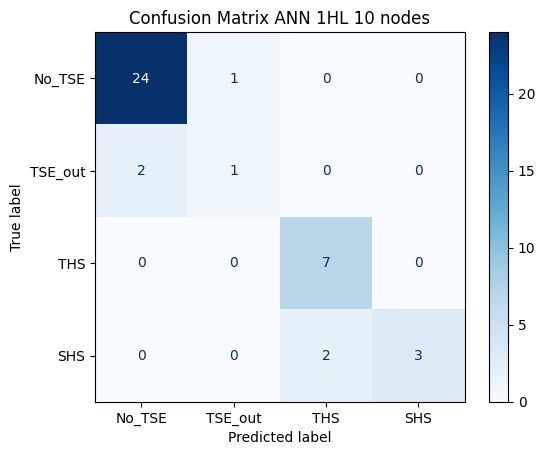

[[24  1  0  0]
 [ 2  1  0  0]
 [ 0  0  7  0]
 [ 0  0  2  3]]


In [58]:
# Predict on validation data
group_mapping = {0: 'No_TSE', 3: 'TSE_out', 2: 'THS', 1: 'SHS'}

y_pred_probs = best_model.predict(X_valANN_scaled)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)            # Convert probabilities to class labels
y_true = np.argmax(Y_val_ohe, axis=1)               # True class labels

accuracy = accuracy_score(Y_val_ordinal, y_pred)
precision = precision_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass
recall = recall_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass
f1 = f1_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass

# For multiclass ROC-AUC, calculate average over classes
roc_auc = roc_auc_score(Y_val_ordinal, y_proba, multi_class='ovr', average='weighted')

# Create a results table
results_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Value": [accuracy, precision, recall, f1, roc_auc]
})

print("Results Table:")
print(results_table)
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=class_order)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[group_mapping[i] for i in class_order])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix ANN 1HL 10 nodes")
plt.show()

print(conf_matrix)

In [60]:
# Ensure Y_val_ordinal is 1-dimensional
Y_val_ordinal_flat = Y_val_ordinal.values.ravel() if isinstance(Y_val_ordinal, pd.DataFrame) else Y_val_ordinal
y_pred_flat = y_pred.ravel() if isinstance(y_pred, np.ndarray) else y_pred

# Create a DataFrame to compare true labels and predictions, using the index from X_val_df
misclassified_samples = pd.DataFrame({
    "True Label": Y_val_ordinal_flat,
    "Predicted Label": y_pred_flat,
}, index=X_val.index)  # Replace X_val_df with the original DataFrame used to generate X_valLR

# Add a column indicating whether the sample is misclassified
misclassified_samples["Misclassified"] = misclassified_samples["True Label"] != misclassified_samples["Predicted Label"]

# Optionally, map the numeric labels to their class names for easier interpretation
misclassified_samples["True Label Name"] = misclassified_samples["True Label"].map(group_mapping)
misclassified_samples["Predicted Label Name"] = misclassified_samples["Predicted Label"].map(group_mapping)

# Filter the misclassified samples
misclassified = misclassified_samples[misclassified_samples["Misclassified"]]

# Add the ID column from full_ohe based on the index
misclassified_with_id = misclassified.merge(full_ohe[['ID']], left_index=True, right_index=True)

# Display the misclassified samples with ID
print("Misclassified Samples with ID:")
print(misclassified_with_id)


Misclassified Samples with ID:
     True Label  Predicted Label  Misclassified True Label Name  \
139           1                2           True             SHS   
1             3                0           True         TSE_out   
160           0                3           True          No_TSE   
94            1                2           True             SHS   
52            3                0           True         TSE_out   

    Predicted Label Name     ID  
139                  THS  EC206  
1                 No_TSE  EC003  
160              TSE_out  EC237  
94                   THS  EC125  
52                No_TSE  EC066  


In [35]:
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the full training dataset
train_accuracy = best_model.evaluate(X_traintestANN_scaled, Y_traintest_ohe, verbose=0)[1]

# Evaluate the best model on the validation dataset
validation_accuracy = best_model.evaluate(X_valANN_scaled, Y_val_ohe, verbose=0)[1]

print("Training Accuracy", train_accuracy)
print("Validation Accuracy", validation_accuracy)


Best Hyperparameters: {'batch_size': 1, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__init_mode': 'normal', 'model__optimizer': 'sgd'}
Training Accuracy 0.8910256624221802
Validation Accuracy 0.875


In [ ]:
class_order

[0, 3, 2, 1]

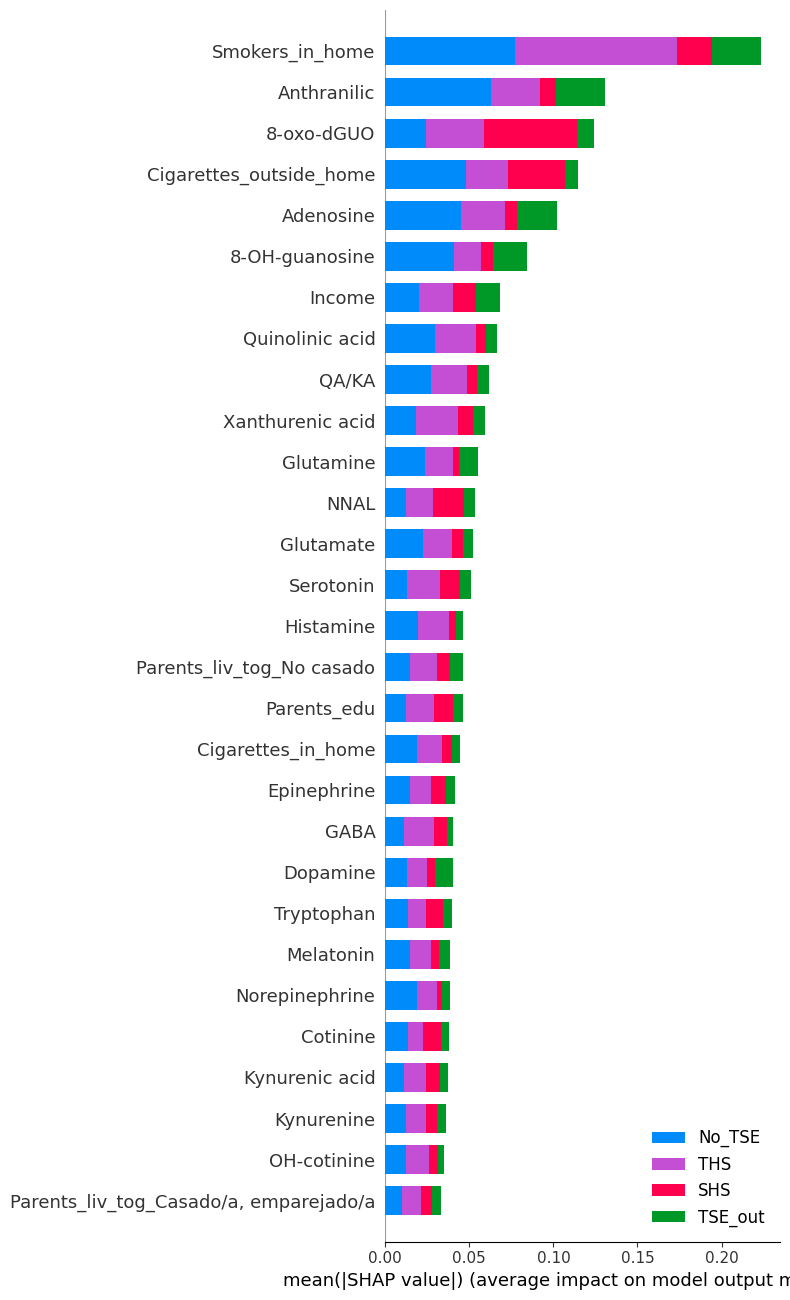

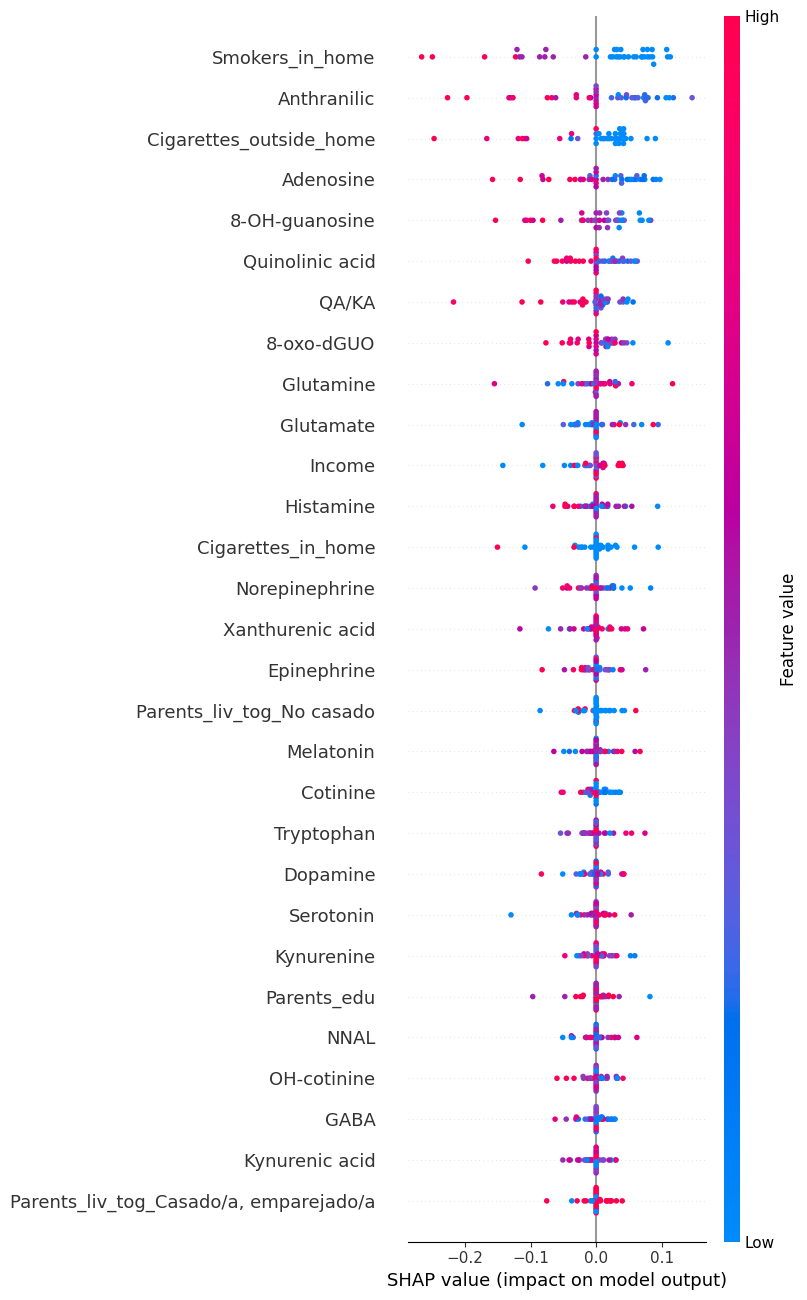

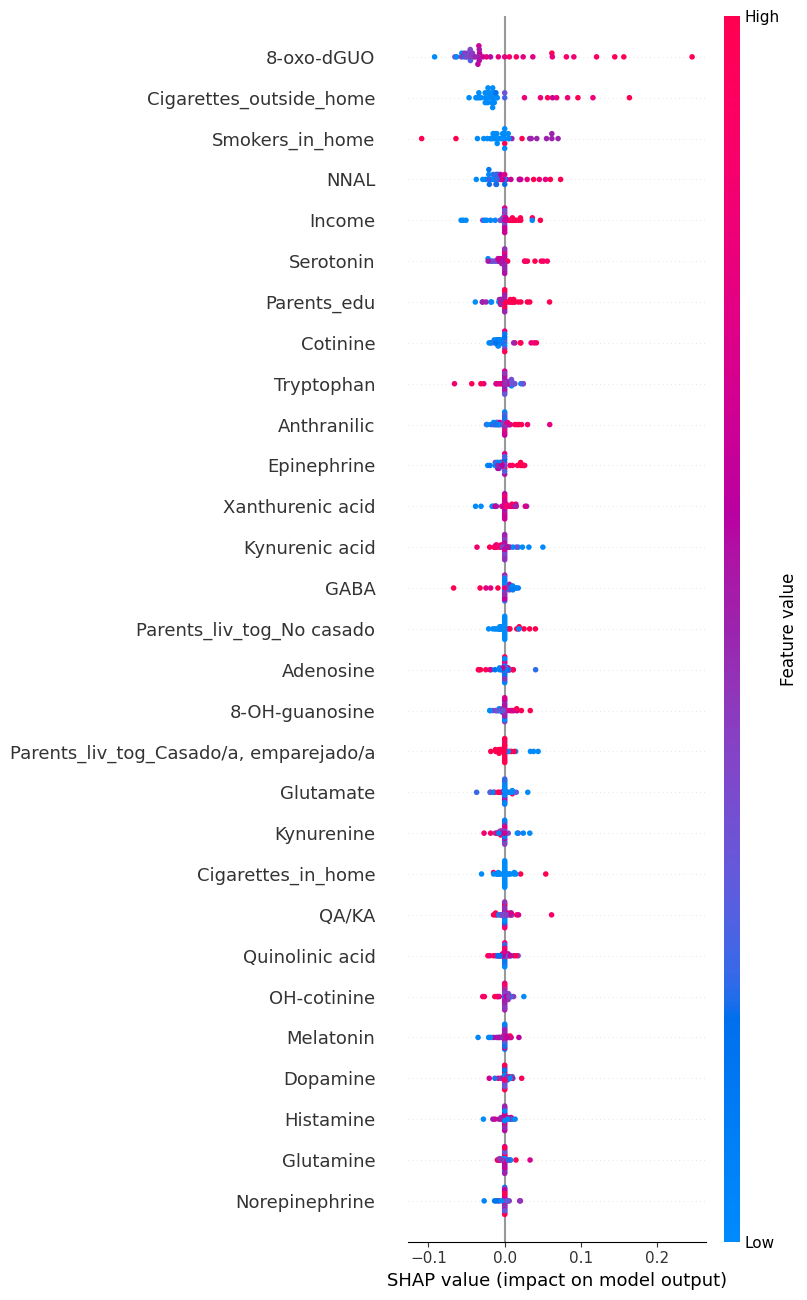

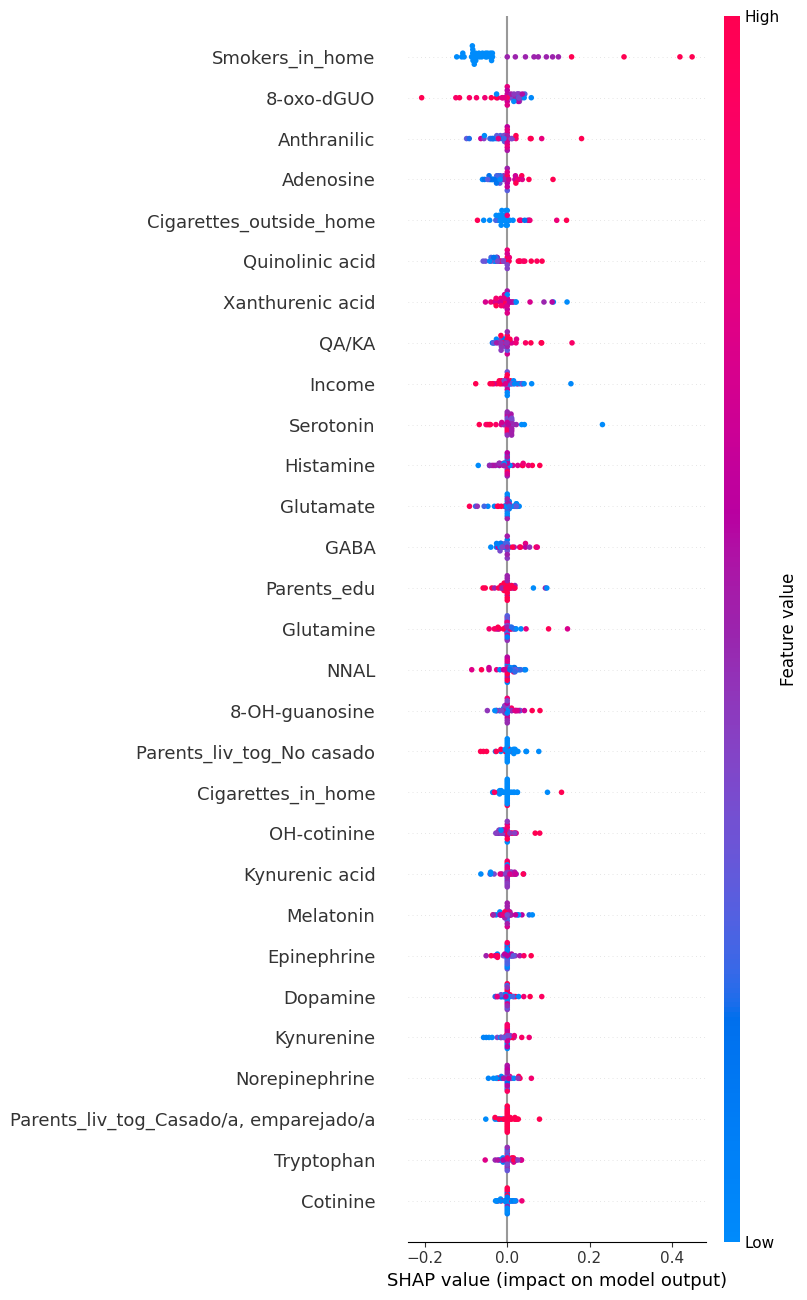

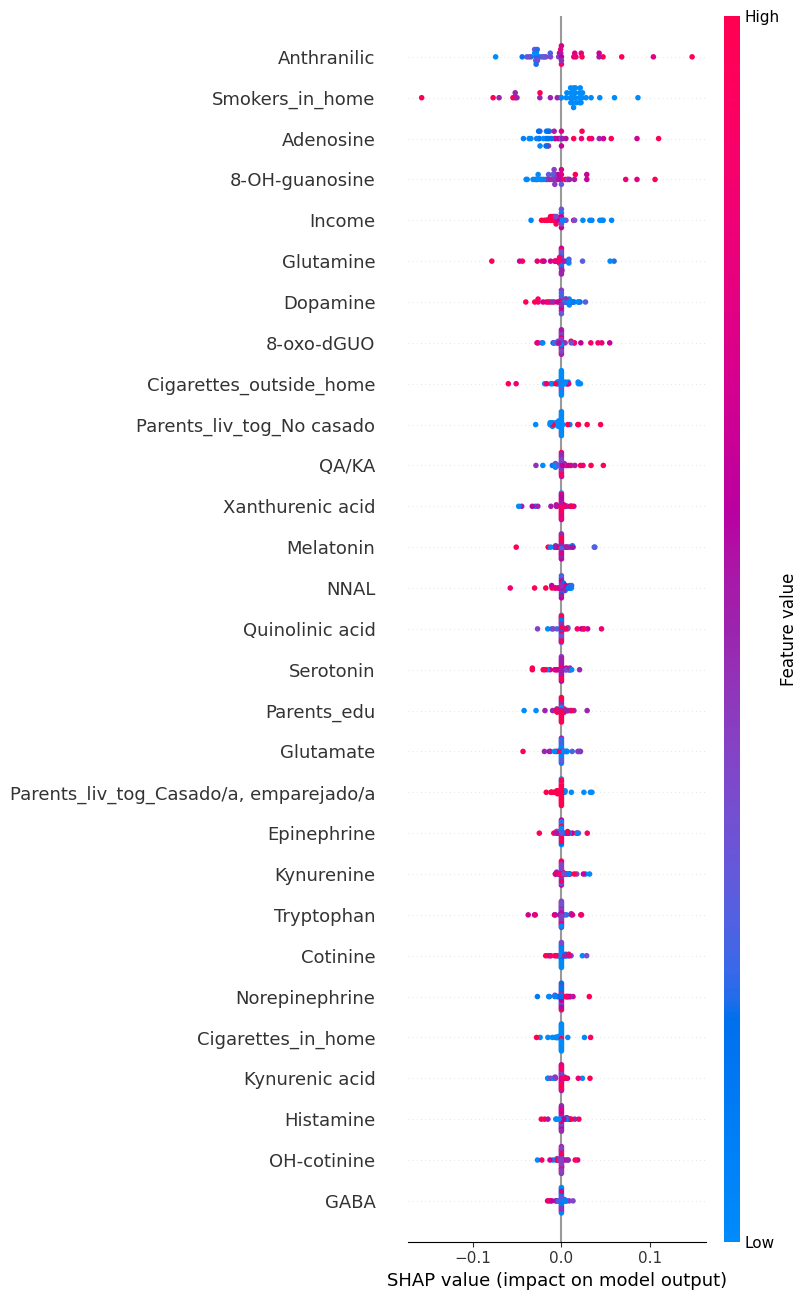

In [ ]:
import shap

# Create a DeepExplainer
explainer = shap.KernelExplainer(best_model.predict,X_valANN_scaled)
shap_values = explainer.shap_values(X_valANN_scaled,nsamples=100)

feature_names = X_val.columns.tolist()
class_order = ['No_TSE', 'SHS', 'THS', 'TSE_out']

# Reshape the SHAP values
shap_values_reshaped = []
for class_idx in range(4):  # For each class
    class_shap = np.array([sample[:, class_idx] for sample in shap_values])
    shap_values_reshaped.append(class_shap)

# Create the summary plot
shap.summary_plot(
    shap_values_reshaped,
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29, # Show all features
    class_names=class_order
)

# Or for a single class:
shap.summary_plot(
    shap_values_reshaped[0],  # For class 0
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29,
    title="SHAP Summary Plot for Class 0"
)

# Or for a single class:
shap.summary_plot(
    shap_values_reshaped[1],  # For class 0
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29
)

shap.summary_plot(
    shap_values_reshaped[2],  # For class 0
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29
)

shap.summary_plot(
    shap_values_reshaped[3],  # For class 0
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29
)

Best Hyperparameters for 1HL 10 nodes
Initializer: uniform, Batch Size: 1, Epochs: 100


2 Hidden Layers with 15 and 7 nodes

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5598 - loss: 1.3447
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6456 - loss: 0.9107
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7580 - loss: 0.7334
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7557 - loss: 0.6079
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7832 - loss: 0.5078
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8248 - loss: 0.4097
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8148 - loss: 0.4904
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.3580
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8522 - loss: 0.3759
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7959 - loss: 0.3867
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7839 - loss: 0.4731
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

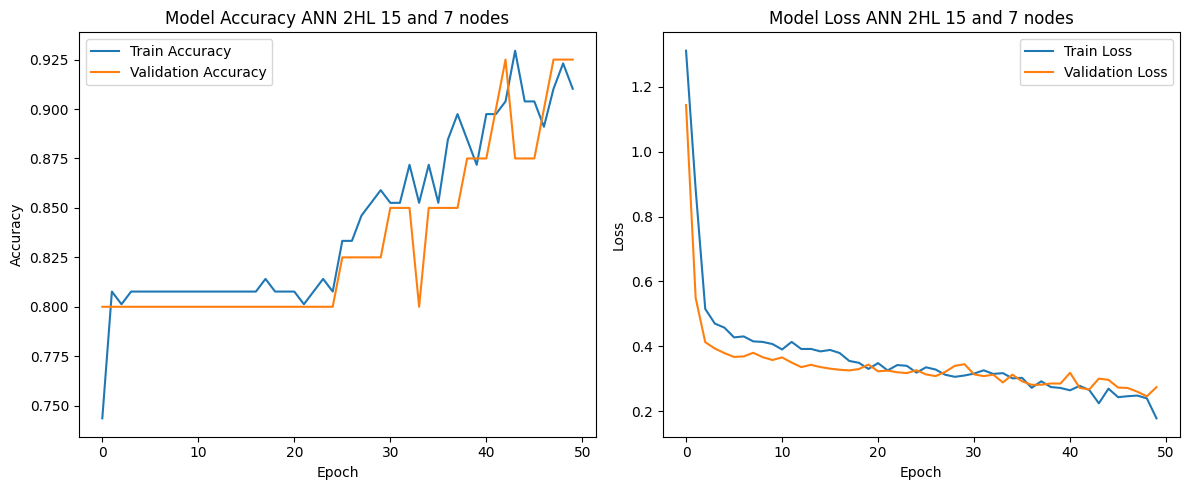

In [61]:
# Create a function that creates a model (required for KerasClassifier) while accepting the hyperparameters we want to tune
def create_model(init_mode='uniform', optimizer='rmsprop', dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(15, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=29))
    model.add(Dropout(dropout_rate))
    model.add(Dense(7, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

    model = Sequential()
    model.add(Dense(10, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=34))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, kernel_initializer=init_mode, activation=tf.nn.softmax))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Define the hyperparameter grid
param_grid = {
    'model__init_mode': ['uniform', 'normal'],
    'model__optimizer': ['rmsprop', 'sgd'],
    'model__dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [1, 5, 10],  # Smaller batch sizes due to limited dataset size
    'epochs': [50]
}

# Create the KerasClassifier wrapper
model = KerasClassifier(model=create_model, verbose=1)

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_traintestANN_scaled, Y_traintest_ohe)

# Display the best hyperparameters and accuracy
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)

# Extract the best model and train it further
best_params = grid_result.best_params_

# Create the best model using the extracted best parameters
best_model = create_model(
    init_mode=best_params['model__init_mode'],
    optimizer=best_params['model__optimizer'],
    dropout_rate=best_params['model__dropout_rate']
)

# Train the best model further
history = best_model.fit(
    X_traintestANN_scaled, Y_traintest_ohe,
    validation_data=(X_valANN_scaled, Y_val_ohe),
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    verbose=1
)

# Function to plot accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy ANN 2HL 15 and 7 nodes')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss ANN 2HL 15 and 7 nodes')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

In [65]:
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the full training dataset
train_accuracy = best_model.evaluate(X_traintestANN_scaled, Y_traintest_ohe, verbose=0)[1]

# Evaluate the best model on the validation dataset
validation_accuracy = best_model.evaluate(X_valANN_scaled, Y_val_ohe, verbose=0)[1]

print("Training Accuracy", train_accuracy)
print("Validation Accuracy", validation_accuracy)


Best Hyperparameters: {'batch_size': 1, 'epochs': 50, 'model__dropout_rate': 0.1, 'model__init_mode': 'normal', 'model__optimizer': 'rmsprop'}
Training Accuracy 0.9166666865348816
Validation Accuracy 0.925000011920929


In [ ]:
print(y_true)
print(y_pred)

[0 0 0 0 0 1 1 1 0 0 0 0 3 0 0 2 0 0 0 0 2 0 1 0 0 2 1 2 0 0 0 0 3 2 2 3 2
 0 0 0]
[0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 2 0 0 0 0 2 0 2 0 0 2 2 2 0 0 0 0 3 2 2 3 2
 0 0 0]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Results Table:
      Metric     Value
0   Accuracy  0.925000
1  Precision  0.947500
2     Recall  0.925000
3   F1 Score  0.915546
4    ROC-AUC  0.987355


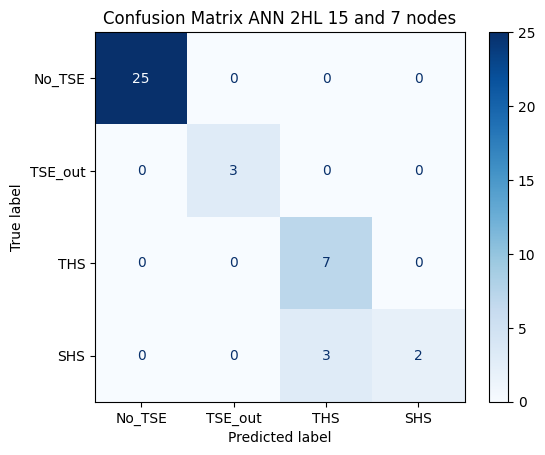

[[25  0  0  0]
 [ 0  3  0  0]
 [ 0  0  7  0]
 [ 0  0  3  2]]


In [69]:
# Predict on validation data
group_mapping = {0: 'No_TSE', 3: 'TSE_out', 2: 'THS', 1: 'SHS'}

y_pred_probs = best_model.predict(X_valANN_scaled)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)            # Convert probabilities to class labels
y_true = np.argmax(Y_val_ohe, axis=1)               # True class labels

accuracy = accuracy_score(Y_val_ordinal, y_pred)
precision = precision_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass
recall = recall_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass
f1 = f1_score(Y_val_ordinal, y_pred, average='weighted')  # Weighted average for multiclass

# For multiclass ROC-AUC, calculate average over classes
roc_auc = roc_auc_score(Y_val_ordinal, y_proba, multi_class='ovr', average='weighted')

# Create a results table
results_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Value": [accuracy, precision, recall, f1, roc_auc]
})

print("Results Table:")
print(results_table)
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=class_order)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[group_mapping[i] for i in class_order])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix ANN 2HL 15 and 7 nodes")
plt.show()

print(conf_matrix)

In [67]:
# Ensure Y_val_ordinal is 1-dimensional
Y_val_ordinal_flat = Y_val_ordinal.values.ravel() if isinstance(Y_val_ordinal, pd.DataFrame) else Y_val_ordinal
y_pred_flat = y_pred.ravel() if isinstance(y_pred, np.ndarray) else y_pred

# Create a DataFrame to compare true labels and predictions, using the index from X_val_df
misclassified_samples = pd.DataFrame({
    "True Label": Y_val_ordinal_flat,
    "Predicted Label": y_pred_flat,
}, index=X_val.index)  # Replace X_val_df with the original DataFrame used to generate X_valLR

# Add a column indicating whether the sample is misclassified
misclassified_samples["Misclassified"] = misclassified_samples["True Label"] != misclassified_samples["Predicted Label"]

# Optionally, map the numeric labels to their class names for easier interpretation
misclassified_samples["True Label Name"] = misclassified_samples["True Label"].map(group_mapping)
misclassified_samples["Predicted Label Name"] = misclassified_samples["Predicted Label"].map(group_mapping)

# Filter the misclassified samples
misclassified = misclassified_samples[misclassified_samples["Misclassified"]]

# Add the ID column from full_ohe based on the index
misclassified_with_id = misclassified.merge(full_ohe[['ID']], left_index=True, right_index=True)

# Display the misclassified samples with ID
print("Misclassified Samples with ID:")
print(misclassified_with_id)


Misclassified Samples with ID:
     True Label  Predicted Label  Misclassified True Label Name  \
139           1                2           True             SHS   
32            1                2           True             SHS   
94            1                2           True             SHS   

    Predicted Label Name     ID  
139                  THS  EC206  
32                   THS  EC044  
94                   THS  EC125  


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
125/125 ━━━━━━

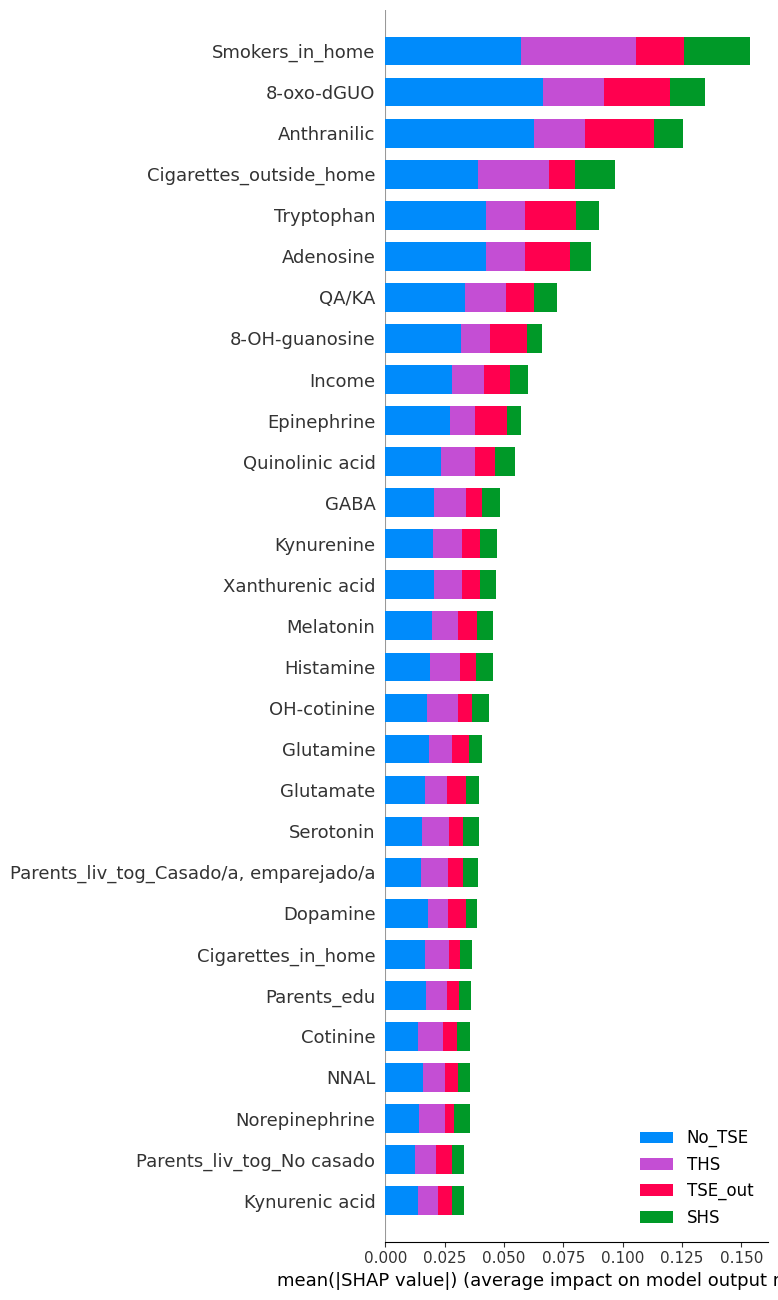

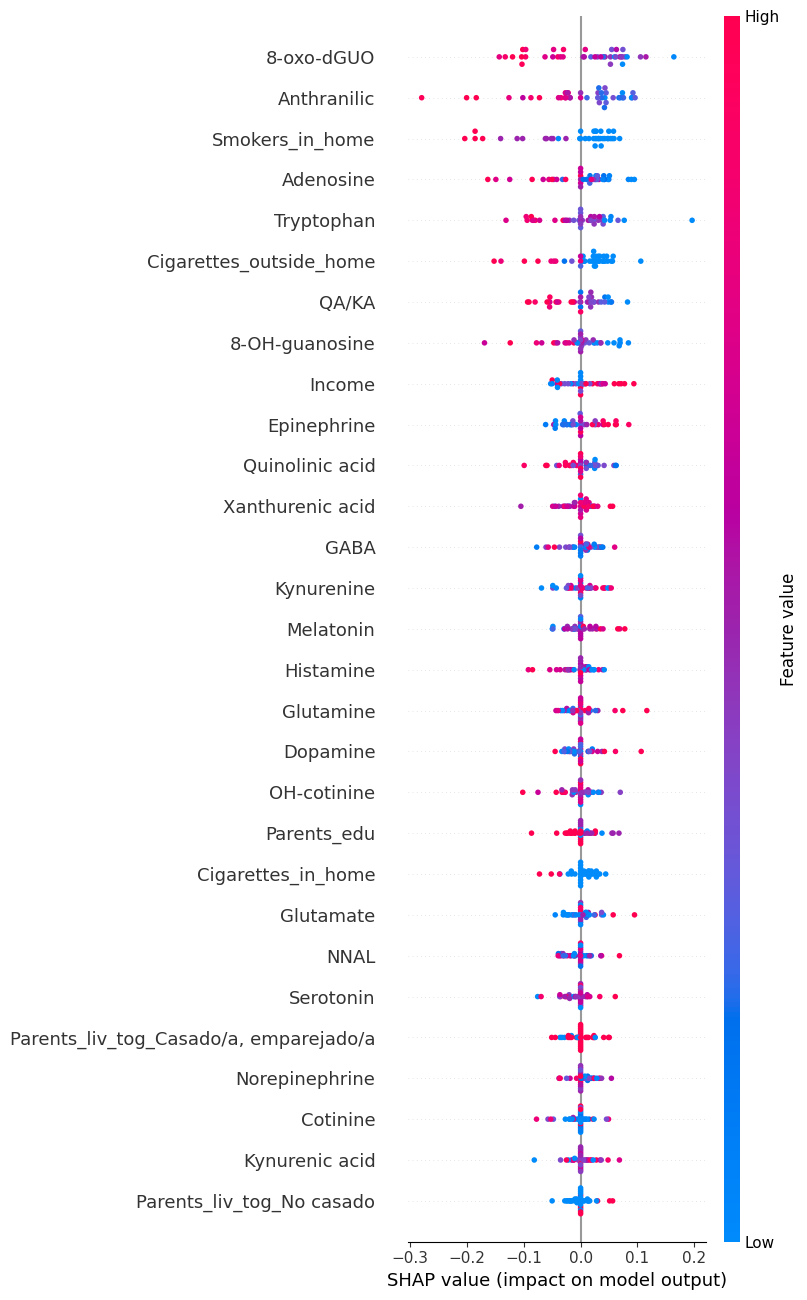

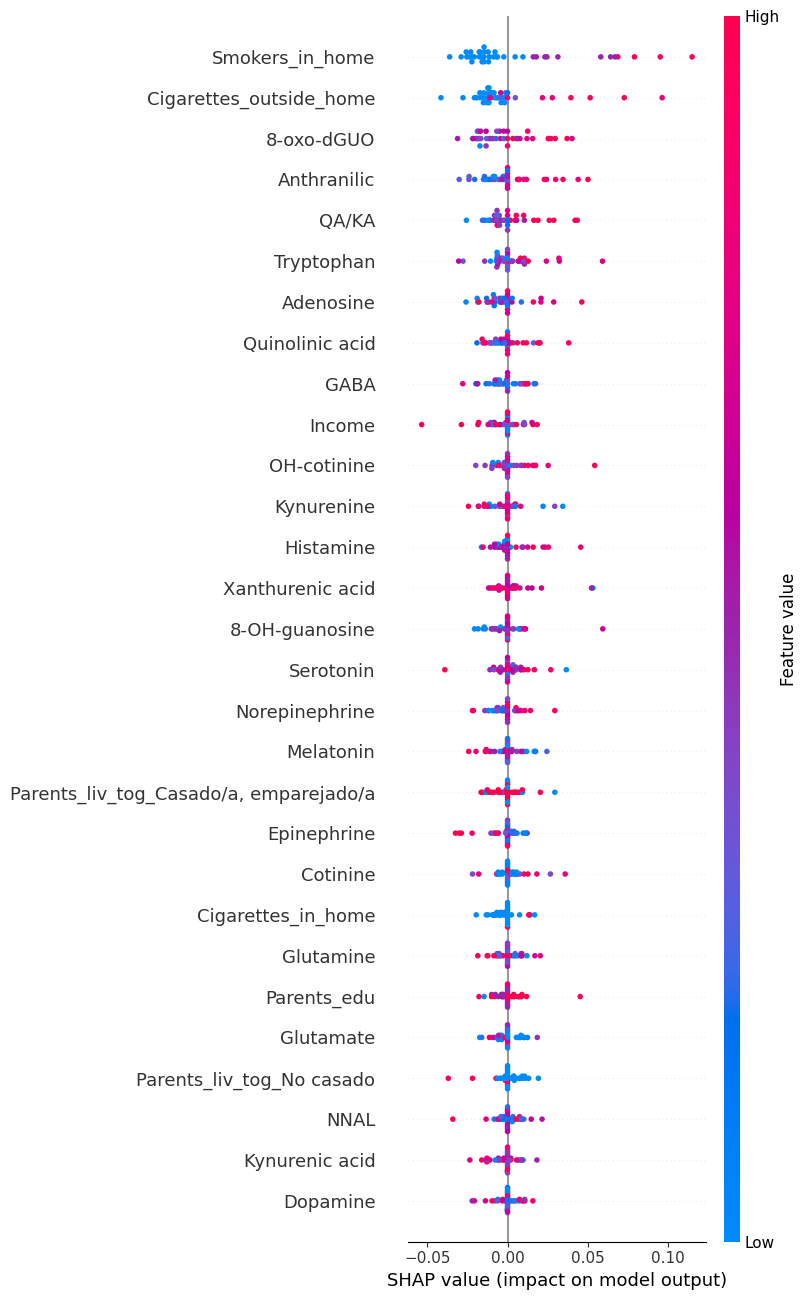

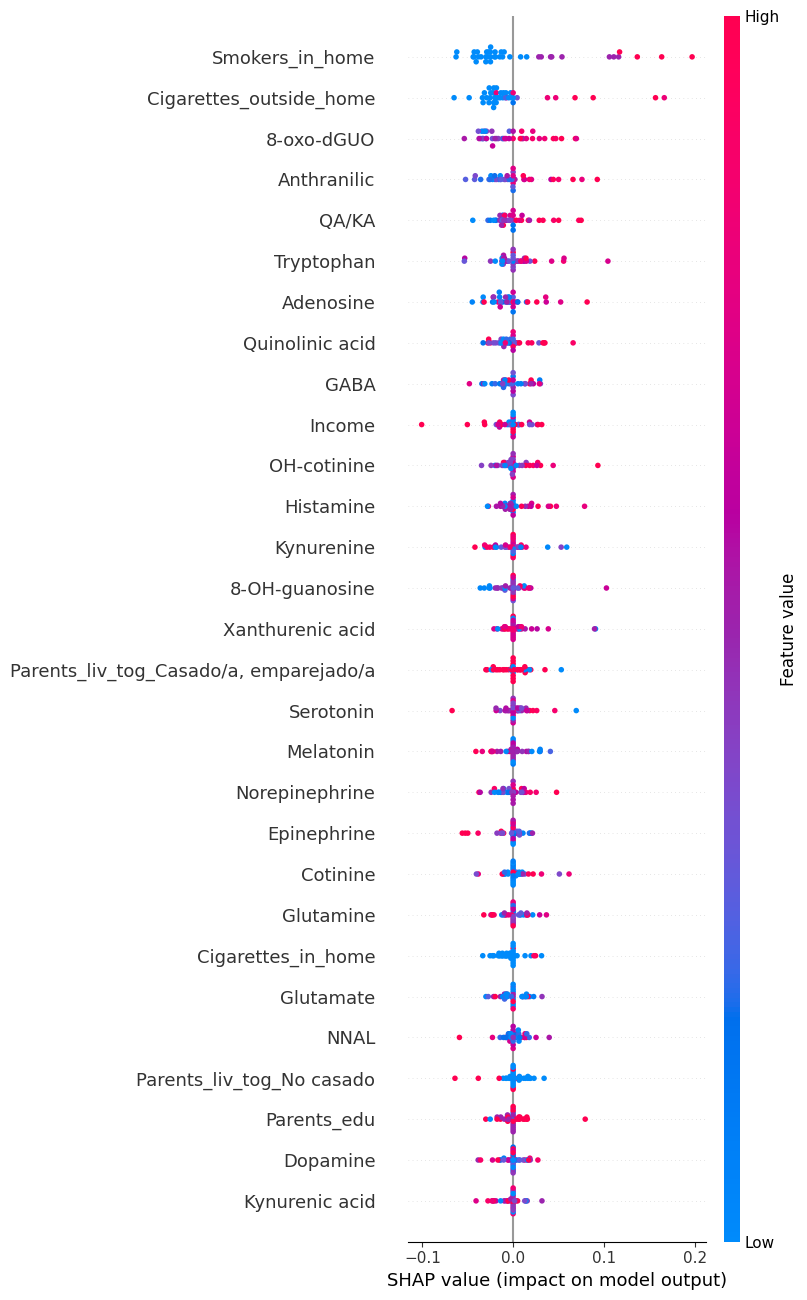

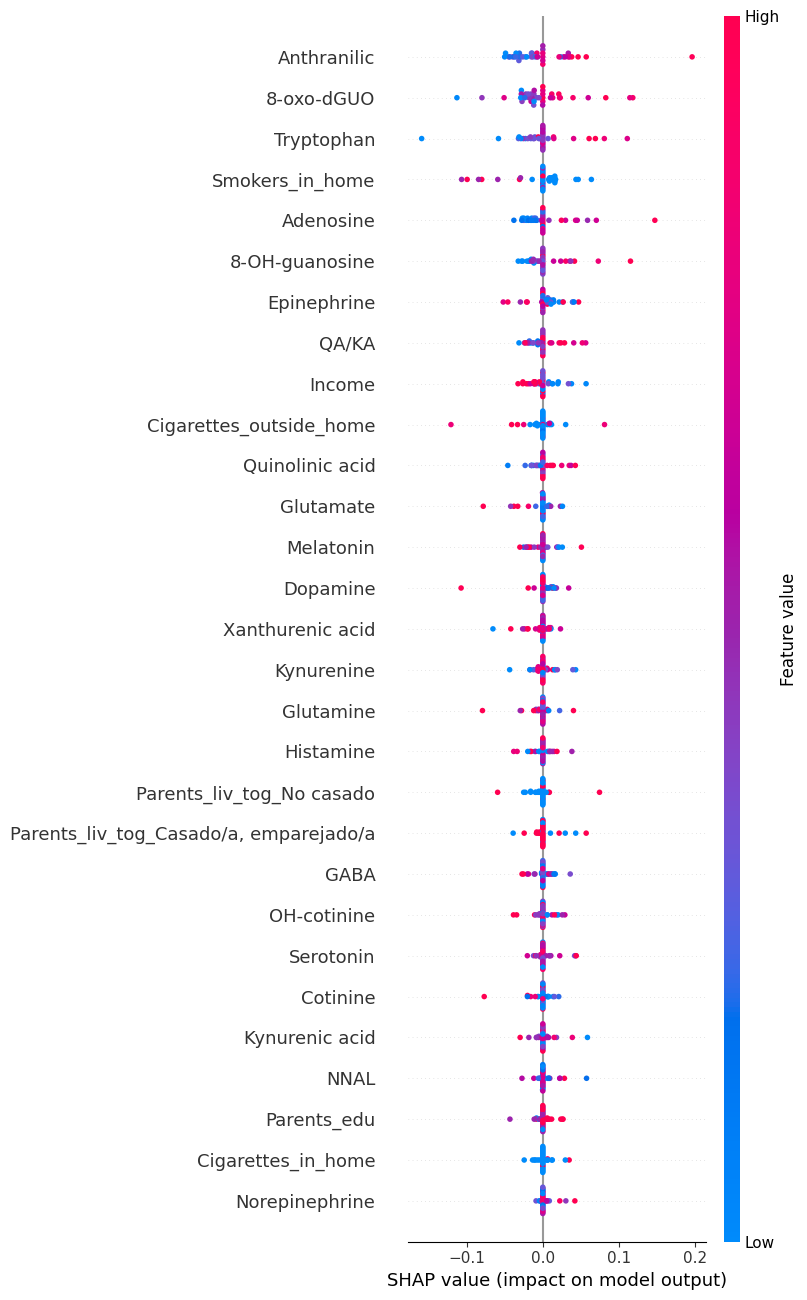

In [ ]:
import shap

# Create a DeepExplainer
explainer = shap.KernelExplainer(best_model.predict,X_valANN_scaled)
shap_values = explainer.shap_values(X_valANN_scaled,nsamples=100)

feature_names = X_val.columns.tolist()
class_order = ['No_TSE', 'SHS', 'THS', 'TSE_out']

# Reshape the SHAP values
shap_values_reshaped = []
for class_idx in range(4):  # For each class
    class_shap = np.array([sample[:, class_idx] for sample in shap_values])
    shap_values_reshaped.append(class_shap)

# Create the summary plot
shap.summary_plot(
    shap_values_reshaped,
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29, # Show all features
    class_names=class_order
)

# Or for a single class:
shap.summary_plot(
    shap_values_reshaped[0],  # For class 0
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29,
    title="SHAP Summary Plot for Class 0"
)

# Or for a single class:
shap.summary_plot(
    shap_values_reshaped[1],  # For class 0
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29
)

shap.summary_plot(
    shap_values_reshaped[2],  # For class 0
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29
)

shap.summary_plot(
    shap_values_reshaped[3],  # For class 0
    X_valANN_scaled,
    feature_names=feature_names,
    max_display=29
)